# **Código Entrega 3 - Datos Bruna**

Resumen resultados obtenidos en el power point

## 1. CARGA DE LOS DATOS COVID

librerias necesarias para carga de datos

In [319]:
# Tratamiento de datos
# =============================================================================================
import pandas as pd

#Instalar Librería para leer el objeto R
!pip install pyreadr --q

import pyreadr # librería para leer archivos generados con R
from urllib.request import urlopen # Necesario para leer el archivo RData con información Covid

import pyreadr # librería para leer archivos generados con R
from urllib.request import urlopen # Necesario para leer el archivo RData con información Covid

In [320]:
# instalamos librería pca
!pip install -q pca
!pip install --upgrade plotly --q

# Tratamiento de datos
# ==============================================================================
import pandas as pd
from pandas.plotting import table
import numpy as np
import statsmodels.api as sm
import pca
import sklearn
import six
import ftplib
import os
import math

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.dates import date2num, num2date
import seaborn as sns
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib import animation
plt.style.use("ggplot")# for pretty graphs
from IPython.display import clear_output
import plotly.express as px
% matplotlib inline

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import k_means
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split


# Configuración warnings
# ==============================================================================
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

leemos los datos del GitHub de Ruben Casal

In [321]:
#Leemos el archivo RData de datos Covid-19 desde el Github de Ruben F. Casal
url="https://github.com/rubenfcasal/COVID-19/blob/master/acumula2.RData?raw=true"
archivo = urlopen(url)
contenido = archivo.read()
fhandle = open('acumula2.RData', 'wb')
fhandle.write(contenido)
fhandle.close()
resultado = pyreadr.read_r("acumula2.RData")

# Convertimos el archivo R a Dataframe Pandas
print(resultado.keys()) # Validamos los objetos que obtenemos de los datos R que serán la base del DataFrame
df_covid = resultado["acumula2"] # Extracción de la información del objeto R hacia Pandas DataFrame
type(df_covid) # Validamos el dipo de objeto generado para confirmar que tenemos nuestro PD DataFrame

df_covid.head(3)

odict_keys(['acumula2'])


,fecha,iso,ccaa,confirmados,hospitalizados,uci,fallecidos
0,2020-01-01,ES,España,0,8,0,0
1,2020-01-01,AN,Andalucía,0,3,0,0
2,2020-01-01,AR,Aragón,0,0,0,0


miramos las características generales de estos datos 

In [322]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12200 entries, 0 to 12199
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   fecha           12200 non-null  object  
 1   iso             11590 non-null  category
 2   ccaa            12200 non-null  category
 3   confirmados     12200 non-null  int32   
 4   hospitalizados  12200 non-null  int32   
 5   uci             12200 non-null  int32   
 6   fallecidos      12200 non-null  int32   
dtypes: category(2), int32(4), object(1)
memory usage: 311.4+ KB


Datos del 1 de enero de 2020 a 01 de septiembre de 2021: 1 año y 7 meses. Hay 11520 entradas

Ahora abro los datos correspondientes a los datos demográficos obtenidos de cada CCAA

In [323]:
url1='https://raw.githubusercontent.com/TFM-BigData-COVID19/BUILDING_DATABASE/main/datos_covid_v4.csv'
df1=pd.read_csv(url1, sep=';', decimal=',')
#informacion de las variables
#print(df1.info())
df1.head(2) 
#df1.columns
#df1.CCAA.unique()

,CCAA,ISO,VIH,Diabetes,trastornos mentales,asma,EPOC,obesidad,tasa_pobreza,nivel_estudios,social,camas_funcionamiento,hospital_dia_funcionamiento,gasto_sanitario,infeccion_hospitalaria,frecuentacion_hospitalizacion,Densidad Poblacional (hab/km2),Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental,Infectados1M(2020),Infectados1M(2021),Hospitalizados1M(2020),Hospitalizados1M(2021),UCI1M(2020),UCI1M(2021),fallecidos1M(2020),fallecidos1M(2021),Vacunados_completos_%
0,Andalucía,AN,7.27,8.25,12.00,4.93,3.42,37.53,32.0,49.0,52.08,77.03,86.98,1264.66,1.33,69.18,96.02,42.48,17.41,8.25,51.61,26.50,8.35,8.66,81.94,20.25,26.50,0.264340,0.318018,0.023783,0.023160,0.002486,0.002776,0.005209,0.004631,7.2
1,Aragón,AR,8.51,7.90,8.62,3.86,4.29,36.80,14.2,35.5,46.57,85.10,86.14,1620.35,1.12,83.99,27.43,45.12,21.73,11.44,58.07,12.54,10.28,10.72,83.71,21.65,12.54,0.079531,0.043616,0.008991,0.003937,0.000828,0.000431,0.002612,0.000876,7.9


quito los datos de ceuta y melilla

In [324]:
#df = df.drop(df[df['C']==True].index)
df1 = df1.drop(df1[df1['CCAA']=='Ceuta y Melilla'].index)
df1.CCAA.unique()

array(['Andalucía', 'Aragón', 'Asturias', 'Canarias', 'Cantabria',
       'Castilla y León', 'Castilla-La Mancha', 'Cataluña',
       'Comunidad Valenciana', 'Extremadura', 'Galicia', 'Islas Baleares',
       'La Rioja', 'Madrid', 'Murcia', 'Navarra', 'País Vasco'],
      dtype=object)

miramos las caracteristicas generales de estos datos demograficos

In [325]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 17
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CCAA                            17 non-null     object 
 1   ISO                             17 non-null     object 
 2   VIH                             17 non-null     float64
 3   Diabetes                        17 non-null     float64
 4   trastornos mentales             17 non-null     float64
 5   asma                            17 non-null     float64
 6   EPOC                            17 non-null     float64
 7   obesidad                        17 non-null     float64
 8   tasa_pobreza                    17 non-null     float64
 9   nivel_estudios                  17 non-null     float64
 10  social                          17 non-null     float64
 11  camas_funcionamiento            17 non-null     float64
 12  hospital_dia_funcionamiento     17 non

Junto las dos tablas y miro sus caracteristicas

In [326]:
df2 = pd.merge(df_covid, df1, left_on='iso', right_on='ISO')
#df2.head(30)
df2.info()
df2.iso.unique()
#df2.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   fecha                           10370 non-null  object  
 1   iso                             10370 non-null  object  
 2   ccaa                            10370 non-null  category
 3   confirmados                     10370 non-null  int32   
 4   hospitalizados                  10370 non-null  int32   
 5   uci                             10370 non-null  int32   
 6   fallecidos                      10370 non-null  int32   
 7   CCAA                            10370 non-null  object  
 8   ISO                             10370 non-null  object  
 9   VIH                             10370 non-null  float64 
 10  Diabetes                        10370 non-null  float64 
 11  trastornos mentales             10370 non-null  float64 
 12  asma              

array(['AN', 'AR', 'AS', 'CN', 'CB', 'CL', 'CM', 'CT', 'VC', 'EX', 'GA',
       'IB', 'RI', 'MD', 'MC', 'NC', 'PV'], dtype=object)

## 2. DATOS DEMOGRAFICOS

### 2. ANALISIS DE LOS DATOS DEMOGRAFICOS - Predicción de infectados

selecciono las columnas con los datos demograficos

In [ ]:
# selecciono las columnas que tocan
datos_demograficos = df2[['fecha','ccaa','confirmados','hospitalizados','fallecidos','uci','Edad Media (años)','Mayores 65 años (%)','Mayores 75 años(%)', 'Índice de dependencia', 'Tasa de Mortalidad (2017)', 'Tasa de Mortalidad (2018)', 'Tasa de Mortalidad (2019)', 'Esperanza_nascer','Esperanza_65años','Mala_salud_mental'  ] ]
#datos_demograficos

datos_demograficos_originales = datos_demograficos

datos_demograficos.info()
datos_demograficos.head(3)
datos_demograficos.ccaa.unique()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   fecha                      10370 non-null  object  
 1   ccaa                       10370 non-null  category
 2   confirmados                10370 non-null  int32   
 3   hospitalizados             10370 non-null  int32   
 4   fallecidos                 10370 non-null  int32   
 5   uci                        10370 non-null  int32   
 6   Edad Media (años)          10370 non-null  float64 
 7   Mayores 65 años (%)        10370 non-null  float64 
 8   Mayores 75 años(%)         10370 non-null  float64 
 9   Índice de dependencia      10370 non-null  float64 
 10  Tasa de Mortalidad (2017)  10370 non-null  float64 
 11  Tasa de Mortalidad (2018)  10370 non-null  float64 
 12  Tasa de Mortalidad (2019)  10370 non-null  float64 
 13  Esperanza_nascer           1037

['Andalucía', 'Aragón', 'Asturias', 'Canarias', 'Cantabria', ..., 'La Rioja', 'Madrid', 'Murcia', 'Navarra', 'País Vasco']
Length: 17
Categories (17, object): ['Andalucía', 'Aragón', 'Asturias', 'Canarias', ..., 'Madrid', 'Murcia',
                          'Navarra', 'País Vasco']

otro metodo para represneytar las cccaa cluster

In [ ]:
metodo 2 oara repeentar las comunidades autonomas

In [ ]:
import datetime
# para aplicar este método todas las variables deben ser numéricas, así que transformamos la variable "fecha" y "ccaa" en numericas:

#fecha
#datos_demograficos.fecha = datos_demograficos.fecha.strftime('%d%m%Y')
nueva_fecha = datos_demograficos['fecha'].apply(lambda x: x.strftime('%d%m%Y')) 
nueva_fecha1 = pd.to_numeric(nueva_fecha, errors='coerce')
#df['A'].apply(lambda x: x.strftime('%d%m%Y'))


pruebo los del cluster

In [ ]:
df_cm2 = datos_demograficos
df_cm2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   fecha                      10370 non-null  object  
 1   ccaa                       10370 non-null  category
 2   confirmados                10370 non-null  int32   
 3   hospitalizados             10370 non-null  int32   
 4   fallecidos                 10370 non-null  int32   
 5   uci                        10370 non-null  int32   
 6   Edad Media (años)          10370 non-null  float64 
 7   Mayores 65 años (%)        10370 non-null  float64 
 8   Mayores 75 años(%)         10370 non-null  float64 
 9   Índice de dependencia      10370 non-null  float64 
 10  Tasa de Mortalidad (2017)  10370 non-null  float64 
 11  Tasa de Mortalidad (2018)  10370 non-null  float64 
 12  Tasa de Mortalidad (2019)  10370 non-null  float64 
 13  Esperanza_nascer           1037

In [ ]:
cols_needed=['Edad Media (años)','Mayores 65 años (%)','Mayores 75 años(%)', 'Índice de dependencia', 'Tasa de Mortalidad (2017)', 'Tasa de Mortalidad (2018)', 'Tasa de Mortalidad (2019)', 'Esperanza_nascer','Esperanza_65años','Mala_salud_mental', 'confirmados',
       'hospitalizados', 'uci', 'fallecidos']

In [ ]:
#data2=data2[~data2.ccaa.isin(excluded_cntry)]
if len(cols_needed)==0:
    data2_sub=df_cm2.select_dtypes(include='float')
else:
    data2_sub=df_cm2[cols_needed]
data2_sub=pd.concat([data2_sub,df_cm2[['ccaa']]],axis=1)
data2_sub=data2_sub.groupby('ccaa').mean().reset_index()
data2_sub.fillna(0,inplace=True)

ValueError: ignored

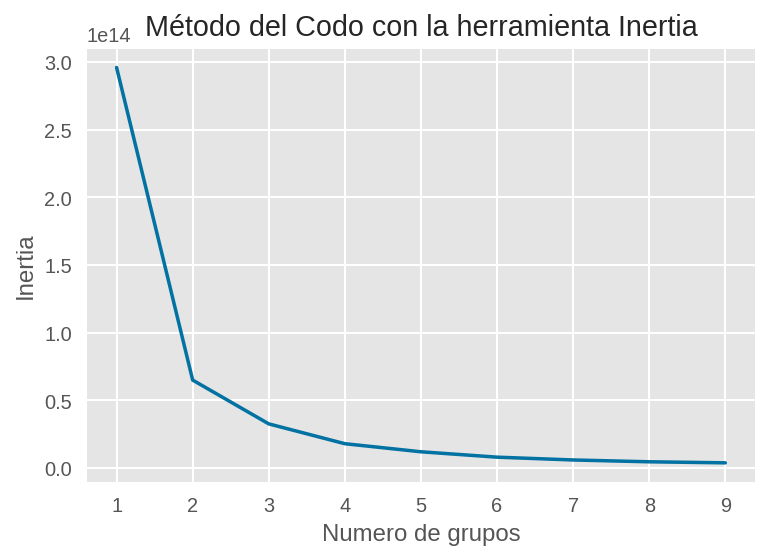

In [ ]:
inertias = [] 
K = range(1,10) 
from sklearn.cluster import KMeans
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(datos_demograficos.drop(['ccaa', 'fecha'],axis=1)) 
    kmeanModel.fit(datos_demograficos.drop(['ccaa','fecha'],axis=1))     
    inertias.append(kmeanModel.inertia_) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Numero de grupos') 
plt.ylabel('Inertia') 
plt.title('Método del Codo con la herramienta Inertia') 
plt.show()

In [ ]:
data2_sub= datos_demograficos.drop(['fecha'], axis=1)
data2_sub.head(2)

,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,Andalucía,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,Andalucía,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


In [ ]:
# ajustado el algoritmo Kmeans ak conjunto de datos
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 4 clústers
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(datos_demograficos.drop(['ccaa', 'fecha'],axis=1))
y_kmeans1 = y_kmeans + 1
cluster = pd.DataFrame(y_kmeans1)
today_sub=datos_demograficos.drop(['ccaa', 'fecha'],axis=1)
# Adding cluster to the Dataset
today_sub['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub.groupby('cluster').mean(),1))

## Identificación de los valores promedio ( centroides) 
kmeans_mean_cluster

,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
cluster,,,,,,,,,,,,,,
1,33986.3,5292.0,1246.7,524.3,44.6,20.6,10.0,54.8,15.5,9.5,9.7,83.4,21.5,15.5
2,624162.7,60341.7,12654.6,5169.2,42.8,18.3,8.8,53.4,19.3,8.0,8.2,83.7,21.7,19.3
3,245752.1,27220.3,6363.3,2316.9,44.7,21.0,10.3,56.5,17.7,9.6,9.8,83.7,21.7,17.7


In [ ]:
today_Sub_2=pd.concat([data2_sub[['ccaa']],today_sub],axis=1)
today_Sub_2.head(1000)

,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental,cluster
0,Andalucía,0,3,0,0,42.48,17.41,8.25,51.61,26.50,8.35,8.66,81.94,20.25,26.50,1
1,Aragón,0,8,0,0,42.48,17.41,8.25,51.61,26.50,8.35,8.66,81.94,20.25,26.50,1
2,Asturias,0,10,0,0,42.48,17.41,8.25,51.61,26.50,8.35,8.66,81.94,20.25,26.50,1
3,Canarias,0,11,0,0,42.48,17.41,8.25,51.61,26.50,8.35,8.66,81.94,20.25,26.50,1
4,Cantabria,0,13,0,0,42.48,17.41,8.25,51.61,26.50,8.35,8.66,81.94,20.25,26.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,90432,9744,2776,890,45.12,21.73,11.44,58.07,12.54,10.28,10.72,83.71,21.65,12.54,1
996,NaN,91178,9819,2794,896,45.12,21.73,11.44,58.07,12.54,10.28,10.72,83.71,21.65,12.54,1
997,NaN,92042,9888,2807,900,45.12,21.73,11.44,58.07,12.54,10.28,10.72,83.71,21.65,12.54,1
998,NaN,92685,9942,2818,908,45.12,21.73,11.44,58.07,12.54,10.28,10.72,83.71,21.65,12.54,1


In [ ]:
for i in range(1,4):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(today_Sub_2[today_Sub_2.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
['Andalucía', 'Aragón', 'Asturias', 'Canarias', 'Cantabria', 'Castilla y León', 'Castilla-La Mancha', 'Cataluña', 'Ceuta y Melilla', 'Comunidad Valenciana', 'España', 'Extremadura', 'Galicia', 'Islas Baleares', 'La Rioja', 'Madrid', 'Murcia', 'Navarra', 'No Consta', 'País Vasco', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [ ]:
import plotly
import plotly.express as px
!pip install --upgrade plotly

In [ ]:
today_Sub_2.head(1)

,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental,cluster
0,Andalucía,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,1


In [ ]:
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='confirmados')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

ValueError: ignored

paso los datos a numerico porque muchos de los métodos ( Arboles de decision, etc) necesitan que los datos estén en formato numerico para que los resultados sean más precisos

In [ ]:
import datetime
# para aplicar este método todas las variables deben ser numéricas, así que transformamos la variable "fecha" y "ccaa" en numericas:

#fecha
#datos_demograficos.fecha = datos_demograficos.fecha.strftime('%d%m%Y')
nueva_fecha = datos_demograficos['fecha'].apply(lambda x: x.strftime('%d%m%Y')) 
nueva_fecha1 = pd.to_numeric(nueva_fecha, errors='coerce')
#df['A'].apply(lambda x: x.strftime('%d%m%Y'))

## ccaa
datos_demograficos['ccaa'] = datos_demograficos['ccaa'].cat.codes
datos_demograficos['fecha'] =  nueva_fecha1
datos_demograficos.info()
datos_demograficos.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fecha                      10370 non-null  int64  
 1   ccaa                       10370 non-null  int8   
 2   confirmados                10370 non-null  int32  
 3   hospitalizados             10370 non-null  int32  
 4   fallecidos                 10370 non-null  int32  
 5   uci                        10370 non-null  int32  
 6   Edad Media (años)          10370 non-null  float64
 7   Mayores 65 años (%)        10370 non-null  float64
 8   Mayores 75 años(%)         10370 non-null  float64
 9   Índice de dependencia      10370 non-null  float64
 10  Tasa de Mortalidad (2017)  10370 non-null  float64
 11  Tasa de Mortalidad (2018)  10370 non-null  float64
 12  Tasa de Mortalidad (2019)  10370 non-null  float64
 13  Esperanza_nascer           10370 non-null  flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,1012020,0,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,2012020,0,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


 K MEANS PARA PROBAR LA PARTE DE CLUSTERING

In [ ]:
!pip install -U yellowbrick

hago el metodo del codo - opcion 1 con libreria yellowbrick

<bound method Visualizer.poof of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f775dd1e050>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=11,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=False, metric='distortion',
                 timings=False)>

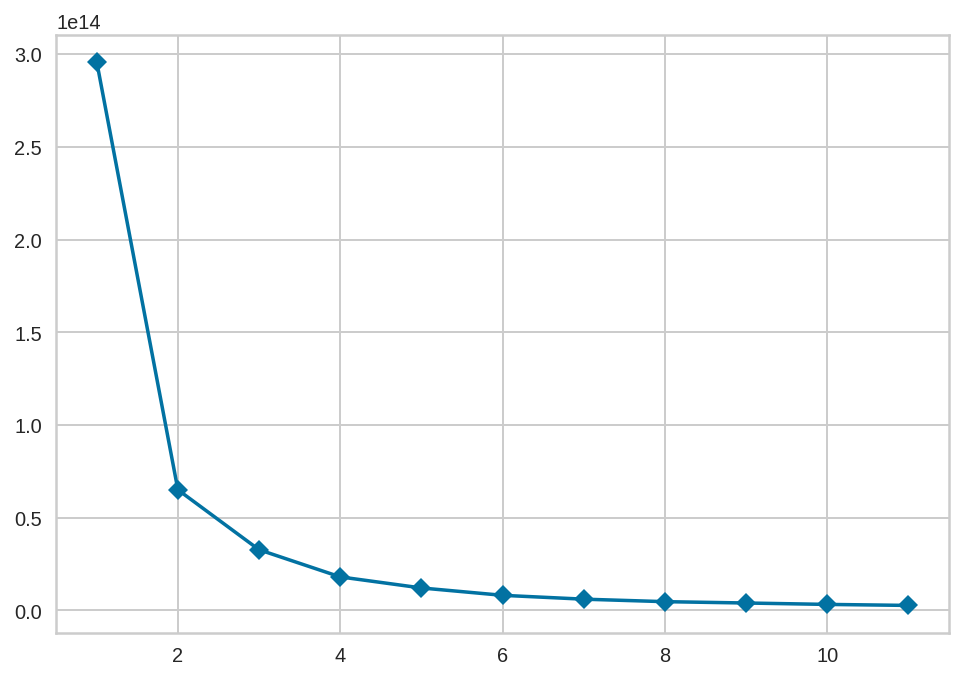

In [ ]:
# selecciono las columnas que tocan, sin la columna de confirmados en ete caso
X = datos_demograficos.drop(['fecha', 'ccaa'], axis=1) 

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False, locate_elbow=False)

visualizer.fit(X)     # Fit the data to the visualizer
visualizer.poof      # Finalize and render the figure


!pip install -U yellowbrick

In [ ]:
# Import the KElbowVisualizer method 
from yellowbrick.cluster import KElbowVisualizer

# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=0)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,12), metric='silhouette', timings=False)

# Fit the data and visualize
visualizer.fit(X)    
visualizer.poof()  

KeyboardInterrupt: ignored

In [ ]:
#Importing required modules
 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

# X.shape dimension inicial es (10980, 16)

#PCA 
pca = PCA(2)
 
#Transform the data - para representar los datos en grafico de 2D
df = pca.fit_transform(X)
 

PCA flattened the dataset. We used PCA to reduce the number of dimensions so that we can visualize the results using a 2D Scatter plot

In [ ]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 2)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
print(label)

In [ ]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

OTRA PAGINA

https://colab.research.google.com/github/jumafernandez/BDM/blob/master/Guias/Guia_Clustering.ipynb#scrollTo=m5WWdVuK_VkY

grafico del metodo del codo con opcion 2 , 

fuente: guia clustring. ypnb

https://colab.research.google.com/github/jumafernandez/BDM/blob/master/Guias/Guia_Clustering.ipynb#scrollTo=m5WWdVuK_VkY

primero hacemos el escalado de las variables

In [ ]:
# Importamos dos módulos para escalado, existen más
# scale: Center to the mean and component wise scale to unit variance
# MinMaxScaler: 
from sklearn.preprocessing import scale, MinMaxScaler

# scale
scaled_1 = scale(X)

# MinMaxScaler
scaler = MinMaxScaler()
scaled_2 = scaler.fit_transform(X)

# Muestro las primeras 5 filas escaladas con scale
print("Escalado con scale:")
print(scaled_1[1:6,])

# Muestro las primeras 5 filas escaladas con Min-Max
print("\nEscalado con Min-Max:")
print(scaled_2[1:6,])


 Algoritmo K-Medias

Entrenando el modelo

Para entrenar un cluster k-means,  debemos importar _KMeans_ del módulo sklearn.cluster.

Este algoritmo posee diferentes hiper-parámetros que se pueden configurar:

- __init:__ es el método de inicialización de los centroides. En este caso definimos _random_ para que se seleccionen aleatoriamente los puntos.

- __n_clusters:__ definine la cantidad N de clústers que queremos como resultado.

- __n_init:__ indica cuantas veces veces va a correr el algoritmo con diferentes centroides.

- __random_state:__ es la semilla de la aleatorización.

Al final de ésta guía, en __Referencias & Recursos Web__ podrás encontrar un enlace a la documentación oficial sobre este tema.

In [ ]:
from sklearn.cluster import KMeans

# Por defecto usa la distancia euclidea
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, random_state=0
)

# Para definir una métrica de distancia diferente usar el módulo KMeansClusterer
# kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)

Para realizar el cálculo, ejecutamos el método __fit_predict__ pasando como parámetro el dataset. Éste método realiza el fit y el predict en el mismo momento.

In [ ]:
y_km = km.fit_predict(scaled_1)

Esto da como resultado un array con el número de clúster (empieza en 0!) al que pertenece cada observación.

In [ ]:
print(y_km)

Ahora vamos a graficar los clústeres, utilizamos Matplotlib. La mejor forma de ver como se comportan los datos es con un gráfico de dispersión (scatter).

La documentación completa de matplotlib.pyplot se puede consultar acá [2].  **HAY QUE MEJORAR ESTA GRAFICA**

In [ ]:
import matplotlib.pyplot as plt

#configuro el tamaño del grafico final
plt.figure(figsize=(10,7))

#scatter del primer cluster
plt.scatter(
    scaled_1[y_km == 0, 0], scaled_1[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)
#scatter del segundo cluster
plt.scatter(
    scaled_1[y_km == 1, 0], scaled_1[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)
#scatter del tercer cluster
plt.scatter(
    scaled_1[y_km == 2, 0], scaled_1[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)



#scatter del los centroides
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroides'
)
#le pongo la leyenda
plt.legend(scatterpoints=1)
#hace una grilla en el grafico
plt.grid()
#lo imprime en pantalla
plt.show()

cluster jerarguico

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
H = linkage(scaled_2, 'single')

In [ ]:
from scipy.spatial.distance import pdist, squareform

squareform(pdist(scaled_2[0:4,]))

In [ ]:
max_d = 7.08
plt.figure(figsize=(25, 10))
plt.title('Dendrograma')
plt.xlabel('Observaciones')
plt.ylabel('Distancia')
dendrogram(
    H, truncate_mode='lastp',
    p=150, leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.axhline(y=max_d, c='k')
plt.show()

 Métricas de evaluación para Clustering

Las métricas mas extendidas en clustering son el método de Elbow y el Índice de Silueta.

El __método de Elbow__ consiste básicamente en verificar la evolución de la suma de los cuadrados del error para varios valores de K y verificar cual es el que brinda un mejor agrupamiento. 

In [ ]:
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(scaled_1)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters *k*')
plt.ylabel('SSE');

Calculamos el primer algoritmo de arboles de decisión

Fuente:  https://www.cienciadedatos.net/documentos/py07_arboles_decision_python.html


para ello usamos las siguientes librerias

In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

In [ ]:
import sklearn

sklearn.__version__

In [ ]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV

# metricas
from sklearn.metrics import mean_squared_error # 1. este hay
from sklearn.metrics import explained_variance_score # 2.
from sklearn.metrics import max_error # 3.
from sklearn.metrics import mean_absolute_error # 4.
from sklearn.metrics import mean_squared_log_error # 5.
from sklearn.metrics import median_absolute_error # 6.
from sklearn.metrics import mean_absolute_percentage_error # 7.
from sklearn.metrics import r2_score # 8.
from sklearn.metrics import mean_poisson_deviance # 9.
from sklearn.metrics import mean_gamma_deviance # 10.
from sklearn.metrics import mean_tweedie_deviance # 11.

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

llamamos los datos demograficos a datos para facilitar los calculos

In [ ]:
datos = datos_demograficos
datos.head(3)

dividimos los datos en train/test, aplicamos el algoritmo del arbol de decision usando la libreria de sklearn para datos contínuos ("numero de confirmados") y entrenamos el modelo con los datos de entrenamiento

In [ ]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "confirmados"),
                                        datos['confirmados'],
                                        random_state = 123
                                    )
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeRegressor(
            max_depth         = 3,
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

Una vez entrenado el árbol, se puede representar mediante la combinación de las funciones plot_tree() y export_text(). La función plot_tree() dibuja la estructura del árbol y muestra el número de observaciones y valor medio de la variable respuesta en cada nodo. La función export_text() representa esta misma información en formato texto.

función plot_tree()

In [ ]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(20, 13))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = datos.drop(columns = "confirmados").columns,
            class_names   = 'confirmados',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )
# para que aparezcan las flechas 
for o in plot:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)

función export_text()

In [ ]:
texto_modelo = export_text(
                    decision_tree = modelo,
                    feature_names = list(datos.drop(columns = "confirmados").columns)
               )
print(texto_modelo)

La importancia de cada predictor en modelo se calcula como la reducción total (normalizada) en el criterio de división, en este caso el mse, que consigue el predictor en las divisiones en las que participa. Si un predictor no ha sido seleccionado en ninguna divisón, no se ha incluido en el modelo y por lo tanto su importancia es 0.

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': datos.drop(columns = "confirmados").columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)


In [ ]:
df_imp = pd.DataFrame(modelo.feature_importances_.reshape(1,-1), columns=datos.drop(columns = "confirmados").columns, index=["Y"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

Tanto con esta forma de calcular como con la otra se observa que los tres factores que más contribuyen para predecir el numero de infectados son los ingresos en UCI, el numero de fallecidos y las ccaa

Con la finalidad de reducir la varianza del modelo y así mejorar la capacidad predictiva, se somete al árbol a un proceso de pruning. Tal como se describió con anterioridad, el proceso de pruning intenta encontrar el árbol más sencillo (menor tamaño) que consigue los mejores resultados de predicción.

Para aplicar el proceso de pruning es necesario indicar el argumento ccp_alpha que determina el grado de penalización por complejidad. Cuanto mayor es este valor, más agresivo el podado y menor el tamaño del árbol resultante. Dado que no hay forma de conocer de antemano el valor óptimo de ccp_alpha, se recurre a validación cruzada para identificarlo.

Aunque existen otras formas de indentificar árboles "optimos", por ejemplo identificando el valor de max_depth y min_samples_split mediante validación cruzada, el pruning puede generar mejores resultados ya que permite que una división poco útil se mantenga si las siguientes divisiones que parten de ella sí lo son.

In [ ]:
# Pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 80, 20)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible para luego aplicar el pruning
        estimator = DecisionTreeRegressor(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [ ]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

Una vez identificado el valor óptimo de ccp_alpha, se reentrena el árbol indicando este valor en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

In [ ]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

fig, ax = plt.subplots(figsize=(27, 25))
plot = plot_tree(
            decision_tree = modelo_final,
            feature_names = datos.drop(columns = "confirmados").columns,
            class_names   = 'MEDV',
            filled        = True,
            impurity      = False,
            ax            = ax
       )

El proceso de pruning a identificado como mejor árbol uno mucho mayor que el modelo inicialmente entrenado.

**Predicción y evaluación del modelo**


Por último, se evalúa la capacidad predictiva del primer árbol y del árbol final empleando el conjunto de test.

In [ ]:
# Error de test del modelo inicial
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

In [ ]:
# Error de test del modelo final (tras aplicar pruning)
#-------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El proceso de pruning consigue reducir el error rmse del modelo de 39050.7 a 1666.8. Las predicciones del modelo final se alejan en promedio 1793 unidades (1667 personas infectadas) del valor real. Creo que el valor del error ha dado tan alto porque el metodo del arbol de decision obliga a transformar las variables de tipo "string" a numericas. 

In [ ]:
# aseguramos esto nuevamente para aplicar el proximo metodo
datos = datos_demograficos
datos.head(3)

In [ ]:
# MÉTODO 2: KNN

# fuente: https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html

# sns:
import seaborn as sns

# Dimensiones del dataset
# ==============================================================================
datos_demograficos_originales.shape

# Número de datos ausentes por variable
# ==============================================================================
datos_demograficos_originales.isna().sum().sort_values()

# Ninguna variable contiene valores ausente. En el apartado imputación de valores ausentes se muestra varias estrategias de imputación cuando el set de datos está incompleto.

# vuelvo a usar los valores de fecha y ccaa como variables de tipo string
datos_demograficos_originales.info()


In [ ]:
# Ninguna variable contiene valores ausente. En el apartado imputación de valores ausentes se muestra varias estrategias de imputación cuando el set de datos está incompleto.

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.distplot(
    datos_demograficos_originales.confirmados,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('confirmados', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(datos_demograficos_originales.confirmados),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(confirmados)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(datos_demograficos_originales.confirmados),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(confirmados)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

Algunos modelos de machine learning y aprendizaje estadístico requieren que la variable respuesta se distribuya de una forma determinada. Por ejemplo, para los modelos de regresión lineal (LM), la distribución tiene que ser de tipo normal. Para los modelos lineales generalizados (GLM), la distribución tiene que ser de la familia exponencial.

Existen varias librerías en python que permiten identificar a qué distribución se ajustan mejor los datos, una de ellas es fitter. Esta librería permite ajustar cualquiera de las 80 distribuciones implementadas en scipy.

In [ ]:
# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
!pip install fitter
from fitter import Fitter, get_common_distributions

distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(datos_demograficos_originales.confirmados, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

In [ ]:
# Variables numéricas
# ==============================================================================
datos_demograficos_originales.select_dtypes(include=['float64', 'int64', 'int8', 'int32']).describe()
#datos.info()

In [ ]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 20))
axes = axes.flat
columnas_numeric = datos_demograficos_originales.select_dtypes(include=['float64', 'int64', 'int8', 'int32']).columns
columnas_numeric = columnas_numeric.drop('confirmados')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos_demograficos_originales,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

Como el objetivo del estudio es predecir el número de personas infectadas, el análisis de cada variable se hace también en relación a la variable respuesta "infectados". Analizando los datos de esta forma, se pueden empezar a extraer ideas sobre qué variables están más relacionadas con el número de infectados y de qué forma.

In [ ]:
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 20))
axes = axes.flat
columnas_numeric = datos_demograficos_originales.select_dtypes(include=['float64', 'int32']).columns
columnas_numeric = columnas_numeric.drop('confirmados')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = datos_demograficos_originales[colum],
        y           = datos_demograficos_originales['confirmados'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"confirmados vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con precio', fontsize = 10, fontweight = "bold");

Correlación variables numéricas
Algunos modelos (LM, GLM, ...) se ven perjudicados si incorporan predictores altamente correlacionados. Por esta razón, es conveniente estudiar el grado de correlación entre las variables disponibles.

In [ ]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = datos_demograficos_originales.select_dtypes(include=['float64', 'int32']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(100)

In [ ]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)


Estudiamos las variables cualitativas de tipo object, en este caso es la fecha y las ccaa

In [ ]:
# Variables cualitativas (tipo object y category)
# ==============================================================================
datos_demograficos_originales.select_dtypes(include=['object', 'category']).describe()

In [ ]:
# Gráfico para cada variable cualitativa
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flat
columnas_object = datos_demograficos_originales.select_dtypes(include=['object', 'category']).columns

for i, colum in enumerate(columnas_object):
    datos_demograficos_originales[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");


In [ ]:
# Gráfico relación entre el confirmados y cada cada variables cualitativas
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
axes = axes.flat
columnas_object = datos_demograficos_originales.select_dtypes(include=['object','category']).columns

for i, colum in enumerate(columnas_object):
    sns.violinplot(
        x     = colum,
        y     = 'confirmados',
        data  = datos_demograficos_originales,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"confirmados vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución del confirmados por grupo', fontsize = 10, fontweight = "bold");

División train/test

In [ ]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos_demograficos_originales.drop('confirmados', axis = 'columns'),
                                        datos_demograficos_originales['confirmados'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

hacemos transformaciones para mejorar la performance de los métodos


Las clases ColumnTransformer y make_column_transformer del módulo sklearn.compose permiten combinar múltiples transformaciones de preprocesado, especificando a qué columnas se aplica cada una. Como todo transformer, tiene un método de entrenamiento (fit) y otro de transformación (transform) . Esto permite que el aprendizaje de las transformaciones se haga únicamente con observaciones de entrenamiento, y se puedan aplicar después a cualquier conjunto de datos. La idea detrás de este módulo es la siguiente:

Definir todas las transformaciones (escalado, selección, filtrado...) que se desea aplicar y a qué columnas ColumnTransformer(). La selección de columnas puede hacerse por: nombre. índice, máscara booleana, slice, patrón regex, por tipo de columna o con las funciones de selección make_column_selector.

Aprender los parámetros necesarios para dichas transformaciones con las observaciones de entrenamiento .fit().

Aplicar las transformaciones aprendidas a cualquier conjunto de datos .transform().

In [ ]:
# Selección de las variables por típo
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.
numeric_cols = X_train.select_dtypes(include=['float64', 'int32']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

Una vez que se ha definido el objeto ColumnTransformer, con el método fit() se aprenden las transformaciones con los datos de entrenamiento y se aplican a los dos conjuntos con transform().

In [ ]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

ColumnTransformer aplica las operaciones de forma paralela, no de forma secuencial, esto significa que no permite aplicar más de una transformación a una misma columna. En el caso de que sea necesario hacerlo, hay que recurrir a los pipeline, que también agrupan operaciones pero las ejecutan de forma secuencial, de forma que la salida de una operación es la entrada de la siguiente. Si se quieren aplicar varias transformaciones de preprocesado sobre una misma columna, es necesario agruparlas primero en un pipeline

En el siguiente ejemplo se combinan las transormaciones:

Columnas numéricas: se imputan los valores ausentes con la mediana y a continuación se estandarizan.

Columnas categóricas (cualitativas): se imputan los valores ausentes con el valor más frecuente y a continuación se aplica one hot encoding.

In [ ]:
# Selección de las variables por típo
# ==============================================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

numeric_cols = X_train.select_dtypes(include=['float64', 'int32']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

In [ ]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [ ]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================

encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()


# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()

METODO 2. KNN . OTRA APROXIMACION

https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

In [ ]:
# vuelvo a usar los valores de fecha y ccaa como variables de tipo string
datos_demograficos_originales.info()

elimino las variables categoricas (ccaa) y la fecha

In [ ]:
datos_demograficos_originales.drop(['fecha', 'ccaa'], axis=1, inplace=True)
datos_demograficos_originales = pd.get_dummies(datos_demograficos_originales)

creo los datos de training y de test

In [ ]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(datos_demograficos_originales, test_size = 0.3)

x_train = train.drop('confirmados', axis=1)
y_train = train['confirmados']

x_test = test.drop('confirmados', axis = 1)
y_test = test['confirmados']

Pre-procesado - escalado de variables

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

Comprobamos el valor del error para diferentes valores de k

In [ ]:
#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)



dibujamos la grafica - el metodo del codo. Para k=5 se obtiene un minimo local

In [ ]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

Se consigue un rmse minimo de 858.73 usando k=5

Metodo 3- regresion lineal multiple con sklearn: https://stackabuse.com/linear-regression-in-python-with-scikit-learn/
 

In [ ]:
# librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

vemos la distribucion estadistica de los datos numericos

In [ ]:
datos_demograficos_originales.info()

transformamos las variable ccaa en numerica

fuente: https://elmundodelosdatos.com/tecnicas-para-codificar-variables-categoricas-ordinal-one-hot/

In [ ]:
# datos demograficos sin la columna de la fecha y de la ccaa- la ccaaa está codificada como int 
df = datos_demograficos_originales.drop(columns= 'fecha')
df.info()

dividimos los datos en training y en test

In [ ]:
X = df.drop('confirmados', axis = 'columns')
#X.info()

Y = df['confirmados']
Y

In [ ]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop('confirmados', axis = 'columns'),
                                        df['confirmados'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

entrenamos el algoritmo

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

se busca los mejores coeficientes de los atributes para la regresion linear multiple

In [ ]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

Adaptar comentario: This means that for a unit increase in "petrol_tax", there is a decrease of 24.19 million gallons in gas consumption. Similarly, a unit increase in proportion of population with a drivers license results in an increase of 1.324 billion gallons of gas consumption. We can see that "Average_income" and "Paved_Highways" have a very little effect on the gas consumption.

hacemos la prediccion con el modelo entrenado y usando los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))


Metodo 4: random forest regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

entrenamos el algoritmo

In [ ]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

metodo del gradiente boosting 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

entrenamos el algoritmo

In [ ]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

hacemos el algoritmos support vector machine 

In [ ]:
from sklearn import svm

entrenamos el algoritmo

In [ ]:
regressor = svm.SVR()
regressor.fit(X_train, y_train)

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

implementamos el algoritmo de adaboost

interesante: https://thinkingneuron.com/how-to-create-the-adaboost-regression-model-in-python/

ejemplo de como dibujar el grafico

https://www.datatechnotes.com/2019/07/regression-example-with.html

In [ ]:
from sklearn.ensemble import AdaBoostRegressor 

entrenamos el algoritmo

In [ ]:
regressor = AdaBoostRegressor ()
regressor.fit(X_train, y_train)

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

hago de nuevo el decision tree regressor con la metodologia usada antes

In [ ]:
from sklearn.tree import DecisionTreeRegressor

entrenamos el algoritmo

In [ ]:
regressor = DecisionTreeRegressor ()
regressor.fit(X_train, y_train)

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Pruebo para KNN de regresion

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

entrenamos el algoritmo

In [ ]:
regressor = KNeighborsRegressor ()
regressor.fit(X_train, y_train)

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

probamos el método BayesianRidge

In [ ]:
from sklearn.linear_model import BayesianRidge

entrenamos el algoritmo

In [ ]:
regressor = BayesianRidge ()
regressor.fit(X_train, y_train)

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

probamos el próximo modelo from SGD Regression

In [ ]:
from sklearn.neural_network import MLPRegressor

entrenamos el algoritmo

In [ ]:
regressor = MLPRegressor()
regressor.fit(X_train, y_train)

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

### 2.A) GRAFICA del METODO DEL CODO OPTIMIZADA Y GRAFICA DEL K MEANS CON CENTROIDE PARA DATOS DEMOGRAFICOS --> Predicción de infectados

https://www.askpython.com/python/examples/plot-k-means-clusters-python

In [ ]:
datos_demograficos.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   fecha                      10370 non-null  object  
 1   ccaa                       10370 non-null  category
 2   confirmados                10370 non-null  int32   
 3   hospitalizados             10370 non-null  int32   
 4   fallecidos                 10370 non-null  int32   
 5   uci                        10370 non-null  int32   
 6   Edad Media (años)          10370 non-null  float64 
 7   Mayores 65 años (%)        10370 non-null  float64 
 8   Mayores 75 años(%)         10370 non-null  float64 
 9   Índice de dependencia      10370 non-null  float64 
 10  Tasa de Mortalidad (2017)  10370 non-null  float64 
 11  Tasa de Mortalidad (2018)  10370 non-null  float64 
 12  Tasa de Mortalidad (2019)  10370 non-null  float64 
 13  Esperanza_nascer           1037

In [ ]:
datos_demograficos.ccaa.unique()

#Importing required modules
 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
 
#Load Data
data = datos_demograficos
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(data)
df.shape

#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
print(label)

TypeError: ignored

In [ ]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

segunda tentiva con otro codigo

https://colab.research.google.com/github/jumafernandez/BDM/blob/master/Guias/Guia_Clustering.ipynb#scrollTo=m5WWdVuK_VkY

In [ ]:
X=datos_demograficos

In [ ]:
# Importamos dos módulos para escalado, existen más
# scale: Center to the mean and component wise scale to unit variance
# MinMaxScaler: 
from sklearn.preprocessing import scale, MinMaxScaler

# scale
scaled_1 = scale(X)

# MinMaxScaler
scaler = MinMaxScaler()
scaled_2 = scaler.fit_transform(X)

# Muestro las primeras 5 filas escaladas con scale
print("Escalado con scale:")
print(scaled_1[1:6,])

# Muestro las primeras 5 filas escaladas con Min-Max
print("\nEscalado con Min-Max:")
print(scaled_2[1:6,])


In [ ]:
from sklearn.cluster import KMeans

# Por defecto usa la distancia euclidea
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, random_state=0
)

# Para definir una métrica de distancia diferente usar el módulo KMeansClusterer
# kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)

Para realizar el cálculo, ejecutamos el método __fit_predict__ pasando como parámetro el dataset. Éste método realiza el fit y el predict en el mismo momento.

In [ ]:
y_km = km.fit_predict(scaled_1)

Esto da como resultado un array con el número de clúster (empieza en 0!) al que pertenece cada observación.

In [ ]:
print(y_km)

Ahora vamos a graficar los clústeres, utilizamos Matplotlib. La mejor forma de ver como se comportan los datos es con un gráfico de dispersión (scatter).

La documentación completa de matplotlib.pyplot se puede consultar acá [2].

In [ ]:
import matplotlib.pyplot as plt

#configuro el tamaño del grafico final
plt.figure(figsize=(10,7))

#scatter del primer cluster
plt.scatter(
    scaled_1[y_km == 0, 0], scaled_1[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)
#scatter del segundo cluster
plt.scatter(
    scaled_1[y_km == 1, 0], scaled_1[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)
#scatter del tercer cluster
plt.scatter(
    scaled_1[y_km == 2, 0], scaled_1[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)
#scatter del los centroides
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroides'
)
#le pongo la leyenda
plt.legend(scatterpoints=1)
#hace una grilla en el grafico
plt.grid()
#lo imprime en pantalla
plt.show()

OTRO EJEMPLO:

https://medium.com/analytics-vidhya/implementation-of-principal-component-analysis-pca-in-k-means-clustering-b4bc0aa79cb6

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
datos_demograficos
x = datos_demograficos.iloc[:,3:]

In [ ]:
wcss = []
for i in range(1,11):
   model = KMeans(n_clusters = i, init = "k-means++")
   model.fit(x)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [ ]:
pca = PCA(2)
data = pca.fit_transform(x)

In [ ]:
plt.figure(figsize=(10,10))
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
lbls = [str(x) for x in range(1,len(var)+1)]
plt.bar(x=range(1,len(var)+1), height = var, tick_label = lbls)
plt.show()

In [ ]:
centers = np.array(model.cluster_centers_)
model = KMeans(n_clusters = 3, init = "k-means++")
label = model.fit_predict(data)
plt.figure(figsize=(20,20))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#This is done to find the centroid for each clusters.
plt.legend()
plt.show()

otro ejemplo: https://datascience.stackexchange.com/questions/76464/multidimensional-k-means-wiith-sklearn-centroids-problem-when-plotting

In [ ]:
numClusters= 4
kmeans = KMeans(n_clusters=numClusters).fit(X)
centroids = kmeans.cluster_centers_

# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_

#transform n variiables to 2 principal components to plot
pca = PCA(n_components=2)
pca_fit = pca.fit(X)
principalComponents = pca_fit.transform(X)
principalDf = pd.DataFrame(data = principalComponents
         , columns = ['principal component 1', 'principal component 2'])

colors =['red','green','blue','cyan','yellow', 'lime','orange','coral','brown','peru','khaki','tan']
centroidColor= []
for item in range(numClusters):
  centroidColor.append(colors[item])

dataPointColor=[]
for row in labels:
  dataPointColor.append(colors[row])

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], 
c=dataPointColor, s=50, alpha=0.5)

C_transformed = pca_fit.transform(C)
plt.scatter(C_transformed[:, 0], C_transformed[:, 1], c=centroidColor, s=200, marker=('p'))
plt.show()


otro ejemplo:


### 3. ANALISIS DE LOS DATOS DEMOGRAFICOS - Predicción de hospitalizados

llamamos a las librerias de los 9 metodos de los algoritmos utilizados

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn import svm

# regressor = svm.SVR()
 # aplicar así como método

definimos los datos de train y test, aislando el numero de hospitalizados. Lo primero que vamos a hacer será comprobar el dataset de inicio:

In [ ]:
# df con formato numerico

datos_demograficos.info()
datos_demograficos.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   fecha                      10370 non-null  object  
 1   ccaa                       10370 non-null  category
 2   confirmados                10370 non-null  int32   
 3   hospitalizados             10370 non-null  int32   
 4   fallecidos                 10370 non-null  int32   
 5   uci                        10370 non-null  int32   
 6   Edad Media (años)          10370 non-null  float64 
 7   Mayores 65 años (%)        10370 non-null  float64 
 8   Mayores 75 años(%)         10370 non-null  float64 
 9   Índice de dependencia      10370 non-null  float64 
 10  Tasa de Mortalidad (2017)  10370 non-null  float64 
 11  Tasa de Mortalidad (2018)  10370 non-null  float64 
 12  Tasa de Mortalidad (2019)  10370 non-null  float64 
 13  Esperanza_nascer           1037

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,2020-01-01,Andalucía,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,2020-01-02,Andalucía,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
2,2020-01-03,Andalucía,0,10,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


In [ ]:
datos = datos_demograficos
datos.head(3)

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,2020-01-01,Andalucía,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,2020-01-02,Andalucía,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
2,2020-01-03,Andalucía,0,10,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


<bound method Visualizer.poof of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f775cc10490>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=11,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=False, metric='distortion',
                 timings=False)>

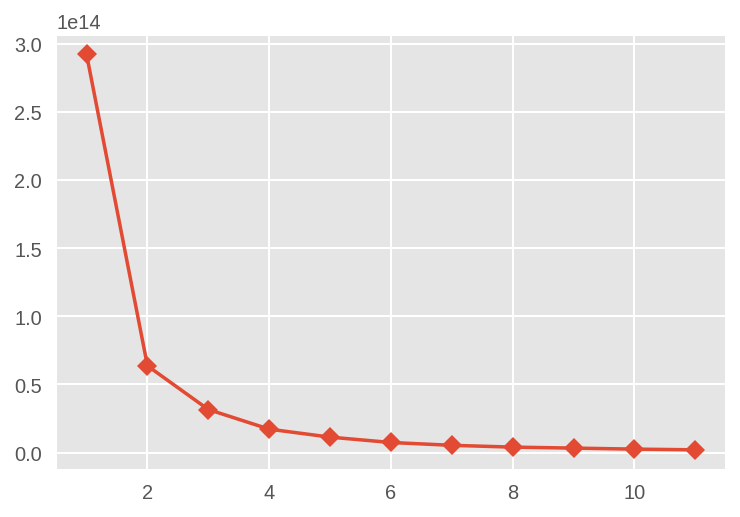

In [ ]:
# selecciono las columnas que tocan, sin la columna de confirmados en ete caso
X = datos_demograficos.drop(['fecha', 'ccaa', 'hospitalizados'], axis=1) 

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False, locate_elbow=False)

visualizer.fit(X)     # Fit the data to the visualizer
visualizer.poof      # Finalize and render the figure


<bound method Visualizer.poof of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7761c61b50>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=11,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=False, metric='distortion',
                 timings=False)>

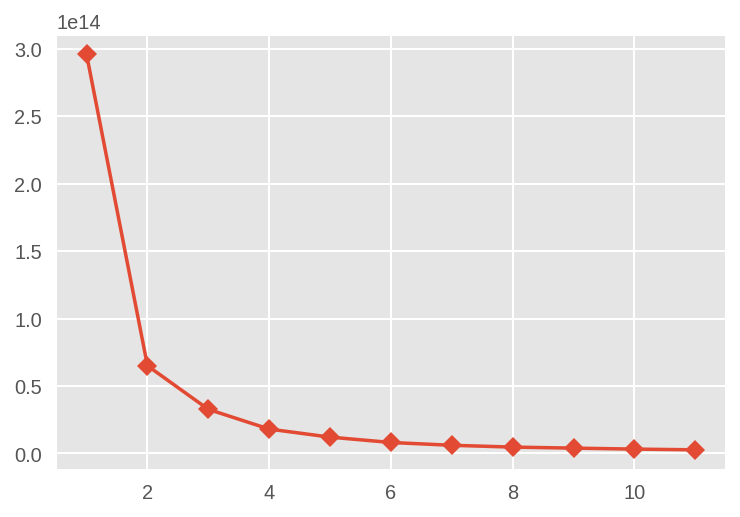

In [ ]:
# selecciono las columnas que tocan, sin la columna de confirmados en ete caso
X = datos_demograficos.drop(['fecha', 'ccaa', 'fallecidos'], axis=1) 

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False, locate_elbow=False)

visualizer.fit(X)     # Fit the data to the visualizer
visualizer.poof      # Finalize and render the figure

dividimos los datos en train/test, aplicamos el algoritmo del arbol de decision usando la libreria de sklearn para datos contínuos ("numero de confirmados") y entrenamos el modelo con los datos de entrenamiento

In [ ]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "hospitalizados"),
                                        datos['hospitalizados'],
                                        random_state = 123
                                    )

NameError: ignored

**Entrenamos el algoritmo - empezamos por :**

**1º) Decision Tree Regressor**

2º) KNeighborsRegressor

3º) Multiple Linear Regression

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = DecisionTreeRegressor ()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 1085.,     0., 38503., ...,  3429., 27189., 43624.])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 1085.     0. 38503. ...  3429. 27189. 43624.]

The DataFrame generated from the NumPy array is:
            0
0      1085.0
1         0.0
2     38503.0
3        56.0
4      6418.0
...       ...
2740   1121.0
2741   3442.0
2742   3429.0
2743  27189.0
2744  43624.0

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,1087,1085.0
7974,1,0.0
8664,38453,38503.0
5541,53,56.0
204,6426,6418.0
...,...,...
1425,1121,1121.0
8437,3446,3442.0
6458,3442,3461.0
3554,27171,27145.0


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 44.42258652094718
median_absolute_error (MAD): 12.0
Root Mean Squared Error (RMSE): 122.04296773882176
mean_absolute_percentage_error (MAPE): 98439336117387.95
max_error(MAX_ERROR): 2115.0
explained_variance_score (EXPL): 0.9999553957603665
R2_SCORE: 0.9999551104928579


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

**2º) KNeighborsRegressor**

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([  852.2,    41. ,  5659.6, ...,  3588.6, 20792.6, 11183.6])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[  852.2    41.   5659.6 ...  3588.6 20792.6 11183.6]

The DataFrame generated from the NumPy array is:
            0
0       852.2
1        41.0
2      5659.6
3        68.8
4      5188.2
...       ...
2740    933.6
2741   3298.0
2742   3588.6
2743  20792.6
2744  11183.6

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,1087,852.2
7974,1,41.0
8664,38453,5659.6
5541,53,68.8
204,6426,5188.2
...,...,...
1425,1121,933.6
8437,3446,3298.0
6458,3442,3588.6
3554,27171,20792.6


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 3855.5089981785068
median_absolute_error (MAD): 984.6000000000004
Root Mean Squared Error (RMSE): 8578.999558258804
mean_absolute_percentage_error (MAPE): 3037837912582591.5
max_error(MAX_ERROR): 47604.600000000006
explained_variance_score (EXPL): 0.7784066984905065
R2_SCORE: 0.7781841333806027


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

**3º) Multiple Linear Regression (LinearRegression)**

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ -467.84196249,  -432.28617587, 43925.10106095, ...,
        2671.06030098, 29068.03659833, 48311.36721225])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ -467.84196249  -432.28617587 43925.10106095 ...  2671.06030098
 29068.03659833 48311.36721225]

The DataFrame generated from the NumPy array is:
                 0
0      -467.841962
1      -432.286176
2     43925.101061
3     -2754.303162
4      3500.949013
...            ...
2740   -393.238003
2741   4067.194821
2742   2671.060301
2743  29068.036598
2744  48311.367212

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,1087,-467.841962
7974,1,-432.286176
8664,38453,43925.101061
5541,53,-2754.303162
204,6426,3500.949013
...,...,...
1425,1121,-393.238003
8437,3446,4067.194821
6458,3442,2671.060301
3554,27171,29068.036598


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 1485.1121041336635
median_absolute_error (MAD): 943.3276972102467
Root Mean Squared Error (RMSE): 2212.631140048767
mean_absolute_percentage_error (MAPE): 1.090897746106689e+17
max_error(MAX_ERROR): 9013.221479075379
explained_variance_score (EXPL): 0.9852492782281862
R2_SCORE: 0.9852450630563621


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

**4ª) Bayesian Ridge Regression**

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = BayesianRidge()
regressor.fit(X_train, y_train)

BayesianRidge()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ -516.60304083,  -418.03321532, 43923.09541303, ...,
        2694.32256336, 29024.61513189, 48307.61430577])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ -516.60304083  -418.03321532 43923.09541303 ...  2694.32256336
 29024.61513189 48307.61430577]

The DataFrame generated from the NumPy array is:
                 0
0      -516.603041
1      -418.033215
2     43923.095413
3     -2742.593008
4      3521.524064
...            ...
2740   -441.996995
2741   4080.469559
2742   2694.322563
2743  29024.615132
2744  48307.614306

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,1087,-516.603041
7974,1,-418.033215
8664,38453,43923.095413
5541,53,-2742.593008
204,6426,3521.524064
...,...,...
1425,1121,-441.996995
8437,3446,4080.469559
6458,3442,2694.322563
3554,27171,29024.615132


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 1484.3623876028846
median_absolute_error (MAD): 944.4159553636564
Root Mean Squared Error (RMSE): 2212.6755128008435
mean_absolute_percentage_error (MAPE): 1.1045164371438928e+17
max_error(MAX_ERROR): 9020.602640845464
explained_variance_score (EXPL): 0.9852484697615477
R2_SCORE: 0.9852444712507854


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

**5º) Random Forest Regressor**

6º) Gradient Boosting

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([1.084360e+03, 1.000000e-01, 3.847949e+04, ..., 3.452940e+03,
       2.715983e+04, 4.375813e+04])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[1.084360e+03 1.000000e-01 3.847949e+04 ... 3.452940e+03 2.715983e+04
 4.375813e+04]

The DataFrame generated from the NumPy array is:
             0
0      1084.36
1         0.10
2     38479.49
3        56.49
4      6418.75
...        ...
2740   1120.96
2741   3443.54
2742   3452.94
2743  27159.83
2744  43758.13

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,1087,1084.36
7974,1,0.10
8664,38453,38479.49
5541,53,56.49
204,6426,6418.75
...,...,...
1425,1121,1120.96
8437,3446,3443.54
6458,3442,3452.94
3554,27171,27159.83


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 30.97836429872497
median_absolute_error (MAD): 5.349999999998545
Root Mean Squared Error (RMSE): 117.1822279470323
mean_absolute_percentage_error (MAPE): 72599010386573.61
max_error(MAX_ERROR): 3082.3600000000006
explained_variance_score (EXPL): 0.9999590029968763
R2_SCORE: 0.9999586150133889


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

**6º) Gradient Boosting**

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 1218.77065974,    64.28573567, 39102.99266413, ...,
        3565.42396606, 27791.79026278, 44239.55512701])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 1218.77065974    64.28573567 39102.99266413 ...  3565.42396606
 27791.79026278 44239.55512701]

The DataFrame generated from the NumPy array is:
                 0
0      1218.770660
1        64.285736
2     39102.992664
3       106.586539
4      6333.431820
...            ...
2740   1218.770660
2741   3521.207406
2742   3565.423966
2743  27791.790263
2744  44239.555127

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,1087,1218.770660
7974,1,64.285736
8664,38453,39102.992664
5541,53,106.586539
204,6426,6333.431820
...,...,...
1425,1121,1218.770660
8437,3446,3521.207406
6458,3442,3565.423966
3554,27171,27791.790263


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 260.483542237786
median_absolute_error (MAD): 146.82369231064877
Root Mean Squared Error (RMSE): 415.48708688211724
mean_absolute_percentage_error (MAPE): 7434769988698903.0
max_error(MAX_ERROR): 4236.325405429459
explained_variance_score (EXPL): 0.9994798123690705
R2_SCORE: 0.9994797232978857


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

**7ª)AdaBoost**

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = AdaBoostRegressor()
regressor.fit(X_train, y_train)

AdaBoostRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 3357.2599278 ,  3357.2599278 , 37337.33154122, ...,
        5952.3104744 , 25606.35965747, 40534.96592317])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 3357.2599278   3357.2599278  37337.33154122 ...  5952.3104744
 25606.35965747 40534.96592317]

The DataFrame generated from the NumPy array is:
                 0
0      3357.259928
1      3357.259928
2     37337.331541
3      3357.259928
4      7721.762042
...            ...
2740   3357.259928
2741   3782.208009
2742   5952.310474
2743  25606.359657
2744  40534.965923

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,1087,3357.259928
7974,1,3357.259928
8664,38453,37337.331541
5541,53,3357.259928
204,6426,7721.762042
...,...,...
1425,1121,3357.259928
8437,3446,3782.208009
6458,3442,5952.310474
3554,27171,25606.359657


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 1896.0017757531768
median_absolute_error (MAD): 1851.951120162932
Root Mean Squared Error (RMSE): 2267.5151497883994
mean_absolute_percentage_error (MAPE): 4.847134430833616e+17
max_error(MAX_ERROR): 8177.898907103823
explained_variance_score (EXPL): 0.988661887547979
R2_SCORE: 0.9845039962766859


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

**8º)Support Vector Machine**

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = svm.SVR()
regressor.fit(X_train, y_train)

SVR()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([4791.63425268, 4843.14067479, 4791.80887855, ..., 4915.34993238,
       4883.78125511, 4897.9479487 ])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[4791.63425268 4843.14067479 4791.80887855 ... 4915.34993238 4883.78125511
 4897.9479487 ]

The DataFrame generated from the NumPy array is:
                0
0     4791.634253
1     4843.140675
2     4791.808879
3     4897.161881
4     4909.848384
...           ...
2740  4915.007460
2741  4903.924012
2742  4915.349932
2743  4883.781255
2744  4897.947949

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,1087,4791.634253
7974,1,4843.140675
8664,38453,4791.808879
5541,53,4897.161881
204,6426,4909.848384
...,...,...
1425,1121,4915.007460
8437,3446,4903.924012
6458,3442,4915.349932
3554,27171,4883.781255


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 9710.514720426883
median_absolute_error (MAD): 4213.093958500885
Root Mean Squared Error (RMSE): 19272.81307181533
mean_absolute_percentage_error (MAPE): 6.974244902465203e+17
max_error(MAX_ERROR): 104150.39377763214
explained_variance_score (EXPL): 2.4248978761853834e-05
R2_SCORE: -0.11946246293317109


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

8º) Support Vector Machine

**9º) Multilayer Perceptron Regressor**

In [ ]:
regressor = MLPRegressor()
regressor.fit(X_train, y_train)

MLPRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 1393.60310645,   109.07883423, 34565.82639587, ...,
        4488.01603677, 30076.8112155 , 39829.9248377 ])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 1393.60310645   109.07883423 34565.82639587 ...  4488.01603677
 30076.8112155  39829.9248377 ]

The DataFrame generated from the NumPy array is:
                 0
0      1393.603106
1       109.078834
2     34565.826396
3       125.928461
4      7690.046809
...            ...
2740   1610.412739
2741   4205.590961
2742   4488.016037
2743  30076.811216
2744  39829.924838

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,1087,1393.603106
7974,1,109.078834
8664,38453,34565.826396
5541,53,125.928461
204,6426,7690.046809
...,...,...
1425,1121,1610.412739
8437,3446,4205.590961
6458,3442,4488.016037
3554,27171,30076.811216


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 2271.1961820844263
median_absolute_error (MAD): 723.7946974138663
Root Mean Squared Error (RMSE): 4559.77848832767
mean_absolute_percentage_error (MAPE): 1.3187265858637664e+16
max_error(MAX_ERROR): 21878.228248633095
explained_variance_score (EXPL): 0.9408692908700885
R2_SCORE: 0.9373376312324282


### 4. ANALISIS DE LOS DATOS DEMOGRAFICOS - Predicción de pacientes en UCI

In [ ]:
# selecciono las columnas que tocan
datos_demograficos = df2[['fecha','ccaa','confirmados','hospitalizados','fallecidos','uci','Edad Media (años)','Mayores 65 años (%)','Mayores 75 años(%)', 'Índice de dependencia', 'Tasa de Mortalidad (2017)', 'Tasa de Mortalidad (2018)', 'Tasa de Mortalidad (2019)', 'Esperanza_nascer','Esperanza_65años','Mala_salud_mental'  ] ]
#datos_demograficos

datos_demograficos_originales = datos_demograficos

datos_demograficos.info()
datos_demograficos.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   fecha                      10370 non-null  object  
 1   ccaa                       10370 non-null  category
 2   confirmados                10370 non-null  int32   
 3   hospitalizados             10370 non-null  int32   
 4   fallecidos                 10370 non-null  int32   
 5   uci                        10370 non-null  int32   
 6   Edad Media (años)          10370 non-null  float64 
 7   Mayores 65 años (%)        10370 non-null  float64 
 8   Mayores 75 años(%)         10370 non-null  float64 
 9   Índice de dependencia      10370 non-null  float64 
 10  Tasa de Mortalidad (2017)  10370 non-null  float64 
 11  Tasa de Mortalidad (2018)  10370 non-null  float64 
 12  Tasa de Mortalidad (2019)  10370 non-null  float64 
 13  Esperanza_nascer           1037

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,2020-01-01,Andalucía,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,2020-01-02,Andalucía,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
2,2020-01-03,Andalucía,0,10,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


In [ ]:
datos_demograficos.ccaa.unique

<bound method Series.unique of 0         Andalucía
1         Andalucía
2         Andalucía
3         Andalucía
4         Andalucía
            ...    
10365    País Vasco
10366    País Vasco
10367    País Vasco
10368    País Vasco
10369    País Vasco
Name: ccaa, Length: 10370, dtype: category
Categories (20, object): ['Andalucía', 'Aragón', 'Asturias', 'Canarias', ..., 'Murcia', 'Navarra',
                          'No Consta', 'País Vasco']>

In [ ]:
datos_demograficos['ccaa'].unique().tolist()

['Andalucía',
 'Aragón',
 'Asturias',
 'Canarias',
 'Cantabria',
 'Castilla y León',
 'Castilla-La Mancha',
 'Cataluña',
 'Comunidad Valenciana',
 'Extremadura',
 'Galicia',
 'Islas Baleares',
 'La Rioja',
 'Madrid',
 'Murcia',
 'Navarra',
 'País Vasco']

paso los datos a numerico porque muchos de los métodos ( Arboles de decision, etc) necesitan que los datos estén en formato numerico para que los resultados sean más precisos

In [ ]:
import datetime
# para aplicar este método todas las variables deben ser numéricas, así que transformamos la variable "fecha" y "ccaa" en numericas:

#fecha
#datos_demograficos.fecha = datos_demograficos.fecha.strftime('%d%m%Y')
nueva_fecha = datos_demograficos['fecha'].apply(lambda x: x.strftime('%d%m%Y')) 
nueva_fecha1 = pd.to_numeric(nueva_fecha, errors='coerce')
#df['A'].apply(lambda x: x.strftime('%d%m%Y'))

## ccaa
datos_demograficos['ccaa'] = datos_demograficos['ccaa'].cat.codes
datos_demograficos['fecha'] =  nueva_fecha1
datos_demograficos.info()
datos_demograficos.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10980 entries, 0 to 10979
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fecha                      10980 non-null  int64  
 1   ccaa                       10980 non-null  int8   
 2   confirmados                10980 non-null  int32  
 3   hospitalizados             10980 non-null  int32  
 4   fallecidos                 10980 non-null  int32  
 5   uci                        10980 non-null  int32  
 6   Edad Media (años)          10980 non-null  float64
 7   Mayores 65 años (%)        10980 non-null  float64
 8   Mayores 75 años(%)         10980 non-null  float64
 9   Índice de dependencia      10980 non-null  float64
 10  Tasa de Mortalidad (2017)  10980 non-null  float64
 11  Tasa de Mortalidad (2018)  10980 non-null  float64
 12  Tasa de Mortalidad (2019)  10980 non-null  float64
 13  Esperanza_nascer           10980 non-null  flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,1012020,0,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,2012020,0,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/scikit_learn-0.24.2.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [ ]:
import sklearn

sklearn.__version__

'0.24.2'

In [ ]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV

# metricas
from sklearn.metrics import mean_squared_error # 1. este hay
from sklearn.metrics import explained_variance_score # 2.
from sklearn.metrics import max_error # 3.
from sklearn.metrics import mean_absolute_error # 4.
from sklearn.metrics import mean_squared_log_error # 5.
from sklearn.metrics import median_absolute_error # 6.
from sklearn.metrics import mean_absolute_percentage_error # 7.
from sklearn.metrics import r2_score # 8.
from sklearn.metrics import mean_poisson_deviance # 9.
from sklearn.metrics import mean_gamma_deviance # 10.
from sklearn.metrics import mean_tweedie_deviance # 11.

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

llamamos a las librerias de los 9 metodos de los algoritmos utilizados

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn import svm

# regressor = svm.SVR()
 # aplicar así como método

definimos los datos de train y test, aislando el numero de hospitalizados. Lo primero que vamos a hacer será comprobar el dataset de inicio:

In [ ]:
# df con formato numerico

datos_demograficos.info()
datos_demograficos.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10980 entries, 0 to 10979
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fecha                      10980 non-null  int64  
 1   ccaa                       10980 non-null  int8   
 2   confirmados                10980 non-null  int32  
 3   hospitalizados             10980 non-null  int32  
 4   fallecidos                 10980 non-null  int32  
 5   uci                        10980 non-null  int32  
 6   Edad Media (años)          10980 non-null  float64
 7   Mayores 65 años (%)        10980 non-null  float64
 8   Mayores 75 años(%)         10980 non-null  float64
 9   Índice de dependencia      10980 non-null  float64
 10  Tasa de Mortalidad (2017)  10980 non-null  float64
 11  Tasa de Mortalidad (2018)  10980 non-null  float64
 12  Tasa de Mortalidad (2019)  10980 non-null  float64
 13  Esperanza_nascer           10980 non-null  flo

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,1012020,0,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,2012020,0,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
2,3012020,0,0,10,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


In [ ]:
datos = datos_demograficos
datos.head(3)

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,1012020,0,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,2012020,0,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
2,3012020,0,0,10,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


dividimos los datos en train/test, aplicamos el algoritmo del arbol de decision usando la libreria de sklearn para datos contínuos ("numero de confirmados") y entrenamos el modelo con los datos de entrenamiento

In [ ]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "uci"),
                                        datos['uci'],
                                        random_state = 123
                                    )
#X_train

**Entrenamos el algoritmo - empezamos por :**

**1º) Decision Tree Regressor**

2º) KNeighborsRegressor

3º) Multiple Linear Regression

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = DecisionTreeRegressor ()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 127.,    0., 2987., ...,  287., 2208., 3359.])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 127.    0. 2987. ...  287. 2208. 3359.]

The DataFrame generated from the NumPy array is:
           0
0      127.0
1        0.0
2     2987.0
3        2.0
4      784.0
...      ...
2740   129.0
2741   383.0
2742   287.0
2743  2208.0
2744  3359.0

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,127,127.0
7974,0,0.0
8664,2986,2987.0
5541,3,2.0
204,784,784.0
...,...,...
1425,129,129.0
8437,383,383.0
6458,287,287.0
3554,2213,2208.0


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 4.143897996357013
median_absolute_error (MAD): 1.0
Root Mean Squared Error (RMSE): 11.335631396711563
mean_absolute_percentage_error (MAPE): 1640655601956.481
max_error(MAX_ERROR): 203.0
explained_variance_score (EXPL): 0.999941461587273
R2_SCORE: 0.999941407774267


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

**2º) KNeighborsRegressor**

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª) AdaBoost

8º) Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([1.0400e+02, 6.0000e-01, 2.0492e+03, ..., 3.9380e+02, 1.8746e+03,
       1.8746e+03])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[1.0400e+02 6.0000e-01 2.0492e+03 ... 3.9380e+02 1.8746e+03 1.8746e+03]

The DataFrame generated from the NumPy array is:
           0
0      104.0
1        0.6
2     2049.2
3        1.2
4      388.8
...      ...
2740   128.0
2741   424.6
2742   393.8
2743  1874.6
2744  1874.6

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,127,104.0
7974,0,0.6
8664,2986,2049.2
5541,3,1.2
204,784,388.8
...,...,...
1425,129,128.0
8437,383,424.6
6458,287,393.8
3554,2213,1874.6


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 245.66673952641165
median_absolute_error (MAD): 97.0
Root Mean Squared Error (RMSE): 495.537372798166
mean_absolute_percentage_error (MAPE): 148643397537256.25
max_error(MAX_ERROR): 3581.6000000000004
explained_variance_score (EXPL): 0.8892252080752115
R2_SCORE: 0.8880300735467529


In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 246.38465967,  -12.77115942, 2499.01967625, ...,  348.09944549,
       2077.39902291, 2944.73033956])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 246.38465967  -12.77115942 2499.01967625 ...  348.09944549 2077.39902291
 2944.73033956]

The DataFrame generated from the NumPy array is:
                0
0      246.384660
1      -12.771159
2     2499.019676
3      377.932358
4      903.428483
...           ...
2740   250.867532
2741   266.137728
2742   348.099445
2743  2077.399023
2744  2944.730340

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,127,246.384660
7974,0,-12.771159
8664,2986,2499.019676
5541,3,377.932358
204,784,903.428483
...,...,...
1425,129,250.867532
8437,383,266.137728
6458,287,348.099445
3554,2213,2077.399023


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 125.8972843273289
median_absolute_error (MAD): 77.95279961664346
Root Mean Squared Error (RMSE): 187.16077165196313
mean_absolute_percentage_error (MAPE): 4.936055919265109e+16
max_error(MAX_ERROR): 801.3536253282473
explained_variance_score (EXPL): 0.9840323581817292
R2_SCORE: 0.9840273042536352


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

**4ª) Bayesian Ridge Regression**

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = BayesianRidge()
regressor.fit(X_train, y_train)

BayesianRidge()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 253.7903659 ,  -15.26032985, 2499.36580304, ...,  344.16631638,
       2084.26583327, 2945.21218454])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 253.7903659   -15.26032985 2499.36580304 ...  344.16631638 2084.26583327
 2945.21218454]

The DataFrame generated from the NumPy array is:
                0
0      253.790366
1      -15.260330
2     2499.365803
3      375.900675
4      899.868068
...           ...
2740   258.284208
2741   263.822798
2742   344.166316
2743  2084.265833
2744  2945.212185

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,127,253.790366
7974,0,-15.260330
8664,2986,2499.365803
5541,3,375.900675
204,784,899.868068
...,...,...
1425,129,258.284208
8437,383,263.822798
6458,287,344.166316
3554,2213,2084.265833


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 125.93738640829773
median_absolute_error (MAD): 77.37415239975235
Root Mean Squared Error (RMSE): 187.1866844264023
mean_absolute_percentage_error (MAPE): 4.950932159046464e+16
max_error(MAX_ERROR): 802.696790274982
explained_variance_score (EXPL): 0.9840274635425638
R2_SCORE: 0.9840228810456004


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

**5º) Random Forest Regressor**

6º) Gradient Boosting

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 127.  ,    0.  , 2984.58, ...,  286.46, 2212.67, 3357.1 ])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 127.      0.   2984.58 ...  286.46 2212.67 3357.1 ]

The DataFrame generated from the NumPy array is:
            0
0      127.00
1        0.00
2     2984.58
3        2.80
4      784.17
...       ...
2740   129.00
2741   382.91
2742   286.46
2743  2212.67
2744  3357.10

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,127,127.00
7974,0,0.00
8664,2986,2984.58
5541,3,2.80
204,784,784.17
...,...,...
1425,129,129.00
8437,383,382.91
6458,287,286.46
3554,2213,2212.67


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 2.744659380692167
median_absolute_error (MAD): 0.7099999999999937
Root Mean Squared Error (RMSE): 7.546300163434293
mean_absolute_percentage_error (MAPE): 10106438508051.838
max_error(MAX_ERROR): 150.6500000000001
explained_variance_score (EXPL): 0.9999740370014691
R2_SCORE: 0.9999740333026236


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

**6º) Gradient Boosting**

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([1.23000724e+02, 2.82070858e+00, 2.99032325e+03, ...,
       3.11067929e+02, 2.20000193e+03, 3.41343964e+03])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[1.23000724e+02 2.82070858e+00 2.99032325e+03 ... 3.11067929e+02
 2.20000193e+03 3.41343964e+03]

The DataFrame generated from the NumPy array is:
                0
0      123.000724
1        2.820709
2     2990.323249
3       26.644611
4      775.268162
...           ...
2740   124.886090
2741   375.499611
2742   311.067929
2743  2200.001928
2744  3413.439639

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,127,123.000724
7974,0,2.820709
8664,2986,2990.323249
5541,3,26.644611
204,784,775.268162
...,...,...
1425,129,124.886090
8437,383,375.499611
6458,287,311.067929
3554,2213,2200.001928


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 32.50386428697702
median_absolute_error (MAD): 20.31041626133026
Root Mean Squared Error (RMSE): 49.96544822045076
mean_absolute_percentage_error (MAPE): 5441410720116662.0
max_error(MAX_ERROR): 341.789171442887
explained_variance_score (EXPL): 0.9988616609132974
R2_SCORE: 0.9988616176850486


adaboost

**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

**7ª)AdaBoost**

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = AdaBoostRegressor()
regressor.fit(X_train, y_train)

AdaBoostRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 286.33881579,  286.33881579, 3340.20489978, ...,  419.        ,
       2407.9298893 , 3752.48328691])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 286.33881579  286.33881579 3340.20489978 ...  419.         2407.9298893
 3752.48328691]

The DataFrame generated from the NumPy array is:
                0
0      286.338816
1      286.338816
2     3340.204900
3      286.338816
4      703.418670
...           ...
2740   286.338816
2741   411.888620
2742   419.000000
2743  2407.929889
2744  3752.483287

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,127,286.338816
7974,0,286.338816
8664,2986,3340.204900
5541,3,286.338816
204,784,703.418670
...,...,...
1425,129,286.338816
8437,383,411.888620
6458,287,419.000000
3554,2213,2407.929889


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 184.36881693062668
median_absolute_error (MAD): 177.6611842105263
Root Mean Squared Error (RMSE): 217.03029986112267
mean_absolute_percentage_error (MAPE): 1.0100342716925477e+17
max_error(MAX_ERROR): 668.3405984484671
explained_variance_score (EXPL): 0.9826848827643587
R2_SCORE: 0.9785222241370605


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

**8º)Support Vector Machine**

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = svm.SVR()
regressor.fit(X_train, y_train)

SVR()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([484.88665781, 501.63979936, 485.07457429, ..., 527.67391628,
       516.31330192, 521.21333246])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[484.88665781 501.63979936 485.07457429 ... 527.67391628 516.31330192
 521.21333246]

The DataFrame generated from the NumPy array is:
               0
0     484.886658
1     501.639799
2     485.074574
3     520.660875
4     525.479704
...          ...
2740  527.475292
2741  523.251297
2742  527.673916
2743  516.313302
2744  521.213332

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,127,484.886658
7974,0,501.639799
8664,2986,485.074574
5541,3,520.660875
204,784,525.479704
...,...,...
1425,129,527.475292
8437,383,523.251297
6458,287,527.673916
3554,2213,516.313302


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 851.1578644933525
median_absolute_error (MAD): 425.4937744502782
Root Mean Squared Error (RMSE): 1563.8653016736366
mean_absolute_percentage_error (MAPE): 1.7766429014800086e+17
max_error(MAX_ERROR): 7780.276991102937
explained_variance_score (EXPL): 0.0005504024157344523
R2_SCORE: -0.11518585604387677


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

8º) Support Vector Machine

**9º) Multilayer Perceptron Regressor**

In [ ]:
regressor = MLPRegressor()
regressor.fit(X_train, y_train)

MLPRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([  89.93819725,  132.84879087, 2313.9892253 , ...,  499.45201892,
       2237.85127388, 2944.53067005])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[  89.93819725  132.84879087 2313.9892253  ...  499.45201892 2237.85127388
 2944.53067005]

The DataFrame generated from the NumPy array is:
                0
0       89.938197
1      132.848791
2     2313.989225
3      211.771686
4      611.647992
...           ...
2740   298.106073
2741   494.991924
2742   499.452019
2743  2237.851274
2744  2944.530670

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,127,89.938197
7974,0,132.848791
8664,2986,2313.989225
5541,3,211.771686
204,784,611.647992
...,...,...
1425,129,298.106073
8437,383,494.991924
6458,287,499.452019
3554,2213,2237.851274


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 186.73447648025845
median_absolute_error (MAD): 136.4983191980896
Root Mean Squared Error (RMSE): 281.56056067898993
mean_absolute_percentage_error (MAPE): 4.6534961963874824e+16
max_error(MAX_ERROR): 2452.1045793885164
explained_variance_score (EXPL): 0.9642110040047633
R2_SCORE: 0.9638513396118731


### 5. ANALISIS DE LOS DATOS DEMOGRAFICOS - Predicción de pacientes fallecidos

cargo los datos 

In [ ]:
# selecciono las columnas que tocan
datos_demograficos = df2[['fecha','ccaa','confirmados','hospitalizados','fallecidos','uci','Edad Media (años)','Mayores 65 años (%)','Mayores 75 años(%)', 'Índice de dependencia', 'Tasa de Mortalidad (2017)', 'Tasa de Mortalidad (2018)', 'Tasa de Mortalidad (2019)', 'Esperanza_nascer','Esperanza_65años','Mala_salud_mental'  ] ]
#datos_demograficos

datos_demograficos_originales = datos_demograficos

datos_demograficos.info()
datos_demograficos.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10980 entries, 0 to 10979
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   fecha                      10980 non-null  object  
 1   ccaa                       10980 non-null  category
 2   confirmados                10980 non-null  int32   
 3   hospitalizados             10980 non-null  int32   
 4   fallecidos                 10980 non-null  int32   
 5   uci                        10980 non-null  int32   
 6   Edad Media (años)          10980 non-null  float64 
 7   Mayores 65 años (%)        10980 non-null  float64 
 8   Mayores 75 años(%)         10980 non-null  float64 
 9   Índice de dependencia      10980 non-null  float64 
 10  Tasa de Mortalidad (2017)  10980 non-null  float64 
 11  Tasa de Mortalidad (2018)  10980 non-null  float64 
 12  Tasa de Mortalidad (2019)  10980 non-null  float64 
 13  Esperanza_nascer           1098

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,2020-01-01,Andalucía,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,2020-01-02,Andalucía,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
2,2020-01-03,Andalucía,0,10,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


paso los datos a numerico porque muchos de los métodos ( Arboles de decision, etc) necesitan que los datos estén en formato numerico para que los resultados sean más precisos

In [ ]:
import datetime
# para aplicar este método todas las variables deben ser numéricas, así que transformamos la variable "fecha" y "ccaa" en numericas:

#fecha
#datos_demograficos.fecha = datos_demograficos.fecha.strftime('%d%m%Y')
nueva_fecha = datos_demograficos['fecha'].apply(lambda x: x.strftime('%d%m%Y')) 
nueva_fecha1 = pd.to_numeric(nueva_fecha, errors='coerce')
#df['A'].apply(lambda x: x.strftime('%d%m%Y'))

## ccaa
datos_demograficos['ccaa'] = datos_demograficos['ccaa'].cat.codes
datos_demograficos['fecha'] =  nueva_fecha1
datos_demograficos.info()
datos_demograficos.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10980 entries, 0 to 10979
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fecha                      10980 non-null  int64  
 1   ccaa                       10980 non-null  int8   
 2   confirmados                10980 non-null  int32  
 3   hospitalizados             10980 non-null  int32  
 4   fallecidos                 10980 non-null  int32  
 5   uci                        10980 non-null  int32  
 6   Edad Media (años)          10980 non-null  float64
 7   Mayores 65 años (%)        10980 non-null  float64
 8   Mayores 75 años(%)         10980 non-null  float64
 9   Índice de dependencia      10980 non-null  float64
 10  Tasa de Mortalidad (2017)  10980 non-null  float64
 11  Tasa de Mortalidad (2018)  10980 non-null  float64
 12  Tasa de Mortalidad (2019)  10980 non-null  float64
 13  Esperanza_nascer           10980 non-null  flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,1012020,0,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,2012020,0,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/scikit_learn-0.24.2.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [ ]:
import sklearn

sklearn.__version__

'0.24.2'

In [ ]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV

# metricas
from sklearn.metrics import mean_squared_error # 1. este hay
from sklearn.metrics import explained_variance_score # 2.
from sklearn.metrics import max_error # 3.
from sklearn.metrics import mean_absolute_error # 4.
from sklearn.metrics import mean_squared_log_error # 5.
from sklearn.metrics import median_absolute_error # 6.
from sklearn.metrics import mean_absolute_percentage_error # 7.
from sklearn.metrics import r2_score # 8.
from sklearn.metrics import mean_poisson_deviance # 9.
from sklearn.metrics import mean_gamma_deviance # 10.
from sklearn.metrics import mean_tweedie_deviance # 11.

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

llamamos a las librerias de los 9 metodos de los algoritmos utilizados

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn import svm

# regressor = svm.SVR()
 # aplicar así como método

definimos los datos de train y test, aislando el numero de hospitalizados. Lo primero que vamos a hacer será comprobar el dataset de inicio:

In [ ]:
# df con formato numerico

datos_demograficos.info()
datos_demograficos.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10980 entries, 0 to 10979
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fecha                      10980 non-null  int64  
 1   ccaa                       10980 non-null  int8   
 2   confirmados                10980 non-null  int32  
 3   hospitalizados             10980 non-null  int32  
 4   fallecidos                 10980 non-null  int32  
 5   uci                        10980 non-null  int32  
 6   Edad Media (años)          10980 non-null  float64
 7   Mayores 65 años (%)        10980 non-null  float64
 8   Mayores 75 años(%)         10980 non-null  float64
 9   Índice de dependencia      10980 non-null  float64
 10  Tasa de Mortalidad (2017)  10980 non-null  float64
 11  Tasa de Mortalidad (2018)  10980 non-null  float64
 12  Tasa de Mortalidad (2019)  10980 non-null  float64
 13  Esperanza_nascer           10980 non-null  flo

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,1012020,0,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,2012020,0,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
2,3012020,0,0,10,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


In [ ]:
datos = datos_demograficos
datos.head(3)

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,1012020,0,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,2012020,0,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
2,3012020,0,0,10,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


dividimos los datos en train/test, aplicamos el algoritmo del arbol de decision usando la libreria de sklearn para datos contínuos ("numero de confirmados") y entrenamos el modelo con los datos de entrenamiento

In [ ]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "fallecidos"),
                                        datos['fallecidos'],
                                        random_state = 123
                                    )
#X_train

**Entrenamos el algoritmo - empezamos por :**

**1º) Decision Tree Regressor**

2º) KNeighborsRegressor

3º) Multiple Linear Regression

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = DecisionTreeRegressor ()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 275.,    0., 7904., ..., 1052., 6817., 8872.])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 275.    0. 7904. ... 1052. 6817. 8872.]

The DataFrame generated from the NumPy array is:
           0
0      275.0
1        0.0
2     7904.0
3        1.0
4     1447.0
...      ...
2740   339.0
2741   771.0
2742  1052.0
2743  6817.0
2744  8872.0

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,276,275.0
7974,0,0.0
8664,7870,7904.0
5541,1,1.0
204,1447,1447.0
...,...,...
1425,339,339.0
8437,770,771.0
6458,1052,1052.0
3554,6819,6817.0


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 9.937704918032788
median_absolute_error (MAD): 2.0
Root Mean Squared Error (RMSE): 40.88234930281409
mean_absolute_percentage_error (MAPE): 1640655601956.4827
max_error(MAX_ERROR): 1624.0
explained_variance_score (EXPL): 0.9998726912667215
R2_SCORE: 0.9998726888097279


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

**2º) KNeighborsRegressor**

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª) AdaBoost

8º) Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 257.6,    0. , 6497.8, ...,  736.2, 5852. , 4823.8])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 257.6    0.  6497.8 ...  736.2 5852.  4823.8]

The DataFrame generated from the NumPy array is:
           0
0      257.6
1        0.0
2     6497.8
3        0.0
4      955.8
...      ...
2740   253.8
2741   644.0
2742   736.2
2743  5852.0
2744  4823.8

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,276,257.6
7974,0,0.0
8664,7870,6497.8
5541,1,0.0
204,1447,955.8
...,...,...
1425,339,253.8
8437,770,644.0
6458,1052,736.2
3554,6819,5852.0


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 658.3908925318761
median_absolute_error (MAD): 298.8000000000002
Root Mean Squared Error (RMSE): 1120.4610791031805
mean_absolute_percentage_error (MAPE): 88595402505650.02
max_error(MAX_ERROR): 5502.6
explained_variance_score (EXPL): 0.9051423758745853
R2_SCORE: 0.904371258602185


In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 390.19885009,  219.02924299, 5326.35290092, ...,  543.98120403,
       5979.88621856, 6331.21026462])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 390.19885009  219.02924299 5326.35290092 ...  543.98120403 5979.88621856
 6331.21026462]

The DataFrame generated from the NumPy array is:
                0
0      390.198850
1      219.029243
2     5326.352901
3       77.790735
4     1405.551832
...           ...
2740   394.992912
2741   752.476099
2742   543.981204
2743  5979.886219
2744  6331.210265

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,276,390.198850
7974,0,219.029243
8664,7870,5326.352901
5541,1,77.790735
204,1447,1405.551832
...,...,...
1425,339,394.992912
8437,770,752.476099
6458,1052,543.981204
3554,6819,5979.886219


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 536.3579044719123
median_absolute_error (MAD): 351.7208397197537
Root Mean Squared Error (RMSE): 831.9144405572665
mean_absolute_percentage_error (MAPE): 3.493344926080592e+17
max_error(MAX_ERROR): 4283.916299308068
explained_variance_score (EXPL): 0.9473328338790671
R2_SCORE: 0.9472828145635611


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

**4ª) Bayesian Ridge Regression**

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = BayesianRidge()
regressor.fit(X_train, y_train)

BayesianRidge()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 397.23968443,  219.07732271, 5324.57556961, ...,  540.49421744,
       5985.39859943, 6329.70799773])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 397.23968443  219.07732271 5324.57556961 ...  540.49421744 5985.39859943
 6329.70799773]

The DataFrame generated from the NumPy array is:
                0
0      397.239684
1      219.077323
2     5324.575570
3       76.181239
4     1402.609226
...           ...
2740   401.956524
2741   752.842454
2742   540.494217
2743  5985.398599
2744  6329.707998

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,276,397.239684
7974,0,219.077323
8664,7870,5324.575570
5541,1,76.181239
204,1447,1402.609226
...,...,...
1425,339,401.956524
8437,770,752.842454
6458,1052,540.494217
3554,6819,5985.398599


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 536.5358807733679
median_absolute_error (MAD): 349.1956757133594
Root Mean Squared Error (RMSE): 831.8858248208521
mean_absolute_percentage_error (MAPE): 3.4904599621697254e+17
max_error(MAX_ERROR): 4287.812139871588
explained_variance_score (EXPL): 0.9473360325115336
R2_SCORE: 0.9472864411748193


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

**5º) Random Forest Regressor**

6º) Gradient Boosting

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 274.19,    0.  , 7884.82, ..., 1049.06, 6819.42, 8871.79])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 274.19    0.   7884.82 ... 1049.06 6819.42 8871.79]

The DataFrame generated from the NumPy array is:
            0
0      274.19
1        0.00
2     7884.82
3        1.00
4     1447.57
...       ...
2740   339.00
2741   770.58
2742  1049.06
2743  6819.42
2744  8871.79

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,276,274.19
7974,0,0.00
8664,7870,7884.82
5541,1,1.00
204,1447,1447.57
...,...,...
1425,339,339.00
8437,770,770.58
6458,1052,1049.06
3554,6819,6819.42


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 6.862185792349731
median_absolute_error (MAD): 0.8900000000001
Root Mean Squared Error (RMSE): 27.21965641809473
mean_absolute_percentage_error (MAPE): 13502595604101.72
max_error(MAX_ERROR): 688.3599999999999
explained_variance_score (EXPL): 0.9999436326473243
R2_SCORE: 0.9999435634876644


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

**6º) Gradient Boosting**

7ª)AdaBoost

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 300.45809369,   19.35906229, 7764.21501394, ...,  889.23867667,
       6742.31655493, 8853.89596628])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 300.45809369   19.35906229 7764.21501394 ...  889.23867667 6742.31655493
 8853.89596628]

The DataFrame generated from the NumPy array is:
                0
0      300.458094
1       19.359062
2     7764.215014
3       14.075139
4     1294.311000
...           ...
2740   317.704623
2741   739.307274
2742   889.238677
2743  6742.316555
2744  8853.895966

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,276,300.458094
7974,0,19.359062
8664,7870,7764.215014
5541,1,14.075139
204,1447,1294.311000
...,...,...
1425,339,317.704623
8437,770,739.307274
6458,1052,889.238677
3554,6819,6742.316555


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 86.9004936390593
median_absolute_error (MAD): 46.85180307838573
Root Mean Squared Error (RMSE): 154.21185905749329
mean_absolute_percentage_error (MAPE): 1.1489890806856732e+16
max_error(MAX_ERROR): 1907.9339912942864
explained_variance_score (EXPL): 0.9981890046549211
R2_SCORE: 0.9981885329664841


adaboost

**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

**7ª)AdaBoost**

8º)Support Vector Machine

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = AdaBoostRegressor()
regressor.fit(X_train, y_train)

AdaBoostRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 624.09251856,  624.09251856, 8168.51206897, ...,  890.88418079,
       7009.45909091, 8686.77302632])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 624.09251856  624.09251856 8168.51206897 ...  890.88418079 7009.45909091
 8686.77302632]

The DataFrame generated from the NumPy array is:
                0
0      624.092519
1      624.092519
2     8168.512069
3      624.092519
4     1189.076225
...           ...
2740   624.092519
2741   890.884181
2742   890.884181
2743  7009.459091
2744  8686.773026

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,276,624.092519
7974,0,624.092519
8664,7870,8168.512069
5541,1,624.092519
204,1447,1189.076225
...,...,...
1425,339,624.092519
8437,770,890.884181
6458,1052,890.884181
3554,6819,7009.459091


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 440.93815096005557
median_absolute_error (MAD): 423.16140350877185
Root Mean Squared Error (RMSE): 505.3181167347719
mean_absolute_percentage_error (MAPE): 3.4096565527640544e+17
max_error(MAX_ERROR): 1586.2868085106384
explained_variance_score (EXPL): 0.9822204855505119
R2_SCORE: 0.980549775107786


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

**8º)Support Vector Machine**

9º) Multilayer Perceptron Regressor

In [ ]:
regressor = svm.SVR()
regressor.fit(X_train, y_train)

SVR()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([866.31365982, 892.59418927, 866.49666506, ..., 928.13273823,
       913.12535712, 919.85578407])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[866.31365982 892.59418927 866.49666506 ... 928.13273823 913.12535712
 919.85578407]

The DataFrame generated from the NumPy array is:
               0
0     866.313660
1     892.594189
2     866.496665
3     919.266727
4     925.448401
...          ...
2740  927.916566
2741  922.605235
2742  928.132738
2743  913.125357
2744  919.855784

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,276,866.313660
7974,0,892.594189
8664,7870,866.496665
5541,1,919.266727
204,1447,925.448401
...,...,...
1425,339,927.916566
8437,770,922.605235
6458,1052,928.132738
3554,6819,913.125357


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 2209.1306184522327
median_absolute_error (MAD): 865.3557597558233
Root Mean Squared Error (RMSE): 3964.3948302723256
mean_absolute_percentage_error (MAPE): 4.897823619242176e+17
max_error(MAX_ERROR): 14958.278080046292
explained_variance_score (EXPL): 0.00025886924541551615
R2_SCORE: -0.19715033570493867


**Entrenamos el algoritmo - empezamos por :**

1º) Decision Tree Regressor

2º) KNeighborsRegressor

3º) Multiple Linear Regression (LinearRegression)

4ª) Bayesian Ridge Regression

5º) Random Forest Regressor

6º) Gradient Boosting

7ª)AdaBoost

8º) Support Vector Machine

**9º) Multilayer Perceptron Regressor**

In [ ]:
regressor = MLPRegressor()
regressor.fit(X_train, y_train)

MLPRegressor()

hacemos la validacion del modelo con los datos de test

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([ 276.56416737,  228.04119781, 5278.59674624, ..., 1115.10631106,
       5898.46182768, 6708.14168178])

trasformamos el array en columna de un df

In [ ]:
from numpy import random
import pandas as pd

print("NumPy Data Array is:")
print(y_pred)

print("")

data_df = pd.DataFrame(y_pred)
print("The DataFrame generated from the NumPy array is:")
print(data_df)

NumPy Data Array is:
[ 276.56416737  228.04119781 5278.59674624 ... 1115.10631106 5898.46182768
 6708.14168178]

The DataFrame generated from the NumPy array is:
                0
0      276.564167
1      228.041198
2     5278.596746
3      313.882147
4     1241.978249
...           ...
2740   506.591162
2741  1054.111979
2742  1115.106311
2743  5898.461828
2744  6708.141682

[2745 rows x 1 columns]


Para comparar los valores de salida reales de X_test con los valores predichos, ejecutamos:

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1344,276,276.564167
7974,0,228.041198
8664,7870,5278.596746
5541,1,313.882147
204,1447,1241.978249
...,...,...
1425,339,506.591162
8437,770,1054.111979
6458,1052,1115.106311
3554,6819,5898.461828


evaluamos el desempeño del algoritmo

In [ ]:
from sklearn import metrics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('median_absolute_error (MAD):', metrics.median_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean_absolute_percentage_error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('max_error(MAX_ERROR):', metrics.max_error(y_test, y_pred))
print('explained_variance_score (EXPL):', metrics.explained_variance_score(y_test, y_pred, multioutput='uniform_average'))
print('R2_SCORE:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 644.258248117825
median_absolute_error (MAD): 325.9984644135079
Root Mean Squared Error (RMSE): 1055.293113609089
mean_absolute_percentage_error (MAPE): 1.289533657461122e+17
max_error(MAX_ERROR): 5428.403717657497
explained_variance_score (EXPL): 0.9151723406268115
R2_SCORE: 0.9151716347553877


## 3. DATOS HOSPITALARIOS

In [327]:
# selecciono las columnas que tocan
datos_hospitalarios= df2[['fecha','ccaa','confirmados','hospitalizados','fallecidos','uci', 'camas_funcionamiento', 'hospital_dia_funcionamiento', 'gasto_sanitario', 'infeccion_hospitalaria', 'frecuentacion_hospitalizacion']]
datos_hospitalarios

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,camas_funcionamiento,hospital_dia_funcionamiento,gasto_sanitario,infeccion_hospitalaria,frecuentacion_hospitalizacion
0,2020-01-01,Andalucía,0,3,0,0,77.03,86.98,1264.66,1.33,69.18
1,2020-01-02,Andalucía,0,8,0,0,77.03,86.98,1264.66,1.33,69.18
2,2020-01-03,Andalucía,0,10,0,0,77.03,86.98,1264.66,1.33,69.18
3,2020-01-04,Andalucía,0,11,0,0,77.03,86.98,1264.66,1.33,69.18
4,2020-01-05,Andalucía,0,13,0,0,77.03,86.98,1264.66,1.33,69.18
...,...,...,...,...,...,...,...,...,...,...,...
10365,2021-08-28,País Vasco,253283,17616,4781,1579,82.07,87.62,1734.72,1.05,85.63
10366,2021-08-29,País Vasco,253566,17616,4782,1579,82.07,87.62,1734.72,1.05,85.63
10367,2021-08-30,País Vasco,253894,17616,4783,1579,82.07,87.62,1734.72,1.05,85.63
10368,2021-08-31,País Vasco,254283,17616,4783,1579,82.07,87.62,1734.72,1.05,85.63


<bound method Visualizer.poof of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7761b79d10>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=11,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=False, metric='distortion',
                 timings=False)>

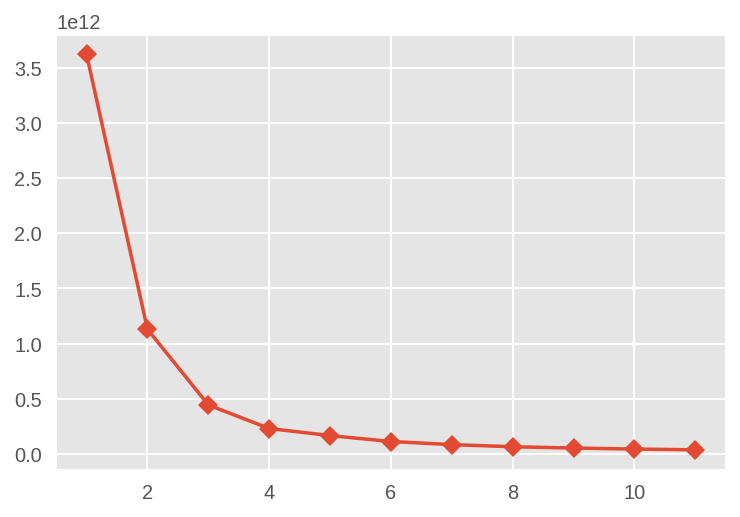

In [ ]:
# CLUSTER PARA INFECTADOS

# selecciono las columnas que tocan, sin la columna de confirmados en ete caso
X = datos_hospitalarios.drop(['fecha', 'ccaa', 'confirmados'], axis=1) 

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False, locate_elbow=False)

visualizer.fit(X)     # Fit the data to the visualizer
visualizer.poof      # Finalize and render the figure

<bound method Visualizer.poof of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7761adb550>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=11,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=False, metric='distortion',
                 timings=False)>

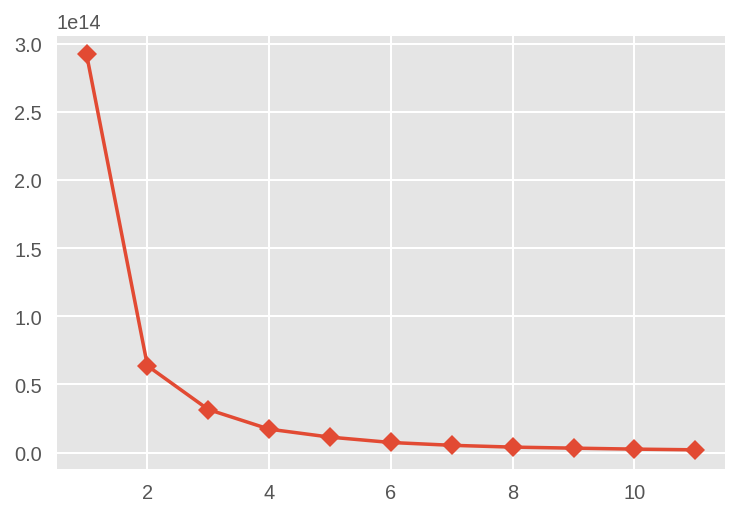

In [ ]:
# CLUSTER PARA INFECTADOS

# selecciono las columnas que tocan, sin la columna de confirmados en ete caso
X = datos_hospitalarios.drop(['fecha', 'ccaa', 'hospitalizados'], axis=1) 

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False, locate_elbow=False)

visualizer.fit(X)     # Fit the data to the visualizer
visualizer.poof      # Finalize and render the figure

<bound method Visualizer.poof of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7761a76b10>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=11,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=False, metric='distortion',
                 timings=False)>

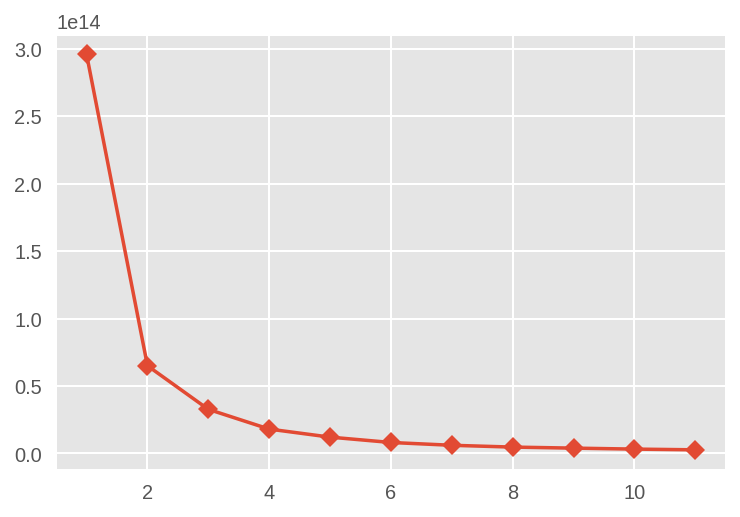

In [ ]:
# CLUSTER PARA INFECTADOS

# selecciono las columnas que tocan, sin la columna de confirmados en ete caso
X = datos_hospitalarios.drop(['fecha', 'ccaa', 'uci'], axis=1) 

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False, locate_elbow=False)

visualizer.fit(X)     # Fit the data to the visualizer
visualizer.poof      # Finalize and render the figure

<bound method Visualizer.poof of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7761adbf10>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=11,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=False, metric='distortion',
                 timings=False)>

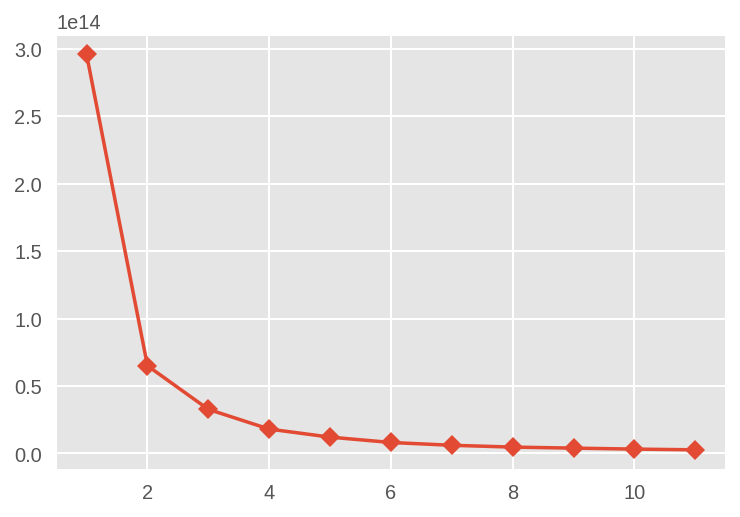

In [ ]:
# CLUSTER PARA INFECTADOS

# selecciono las columnas que tocan, sin la columna de confirmados en ete caso
X = datos_hospitalarios.drop(['fecha', 'ccaa', 'fallecidos'], axis=1) 

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False, locate_elbow=False)

visualizer.fit(X)     # Fit the data to the visualizer
visualizer.poof      # Finalize and render the figure

## 4. DATOS COMORBILIDADES

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   fecha                           10370 non-null  object  
 1   iso                             10370 non-null  object  
 2   ccaa                            10370 non-null  category
 3   confirmados                     10370 non-null  int32   
 4   hospitalizados                  10370 non-null  int32   
 5   uci                             10370 non-null  int32   
 6   fallecidos                      10370 non-null  int32   
 7   CCAA                            10370 non-null  object  
 8   ISO                             10370 non-null  object  
 9   VIH                             10370 non-null  float64 
 10  Diabetes                        10370 non-null  float64 
 11  trastornos mentales             10370 non-null  float64 
 12  asma              

In [350]:
# selecciono las columnas que tocan
datos_comorbilidades= df2[['fecha','ccaa','confirmados','hospitalizados','fallecidos','uci', 'VIH', 'Diabetes', 'trastornos mentales', 'asma', 'EPOC']]
datos_comorbilidades

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,VIH,Diabetes,trastornos mentales,asma,EPOC
0,2020-01-01,Andalucía,0,3,0,0,7.27,8.25,12.00,4.93,3.42
1,2020-01-02,Andalucía,0,8,0,0,7.27,8.25,12.00,4.93,3.42
2,2020-01-03,Andalucía,0,10,0,0,7.27,8.25,12.00,4.93,3.42
3,2020-01-04,Andalucía,0,11,0,0,7.27,8.25,12.00,4.93,3.42
4,2020-01-05,Andalucía,0,13,0,0,7.27,8.25,12.00,4.93,3.42
...,...,...,...,...,...,...,...,...,...,...,...
10365,2021-08-28,País Vasco,253283,17616,4781,1579,7.78,6.86,10.18,4.75,2.46
10366,2021-08-29,País Vasco,253566,17616,4782,1579,7.78,6.86,10.18,4.75,2.46
10367,2021-08-30,País Vasco,253894,17616,4783,1579,7.78,6.86,10.18,4.75,2.46
10368,2021-08-31,País Vasco,254283,17616,4783,1579,7.78,6.86,10.18,4.75,2.46


<bound method Visualizer.poof of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7761a2d9d0>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=11,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=False, metric='distortion',
                 timings=False)>

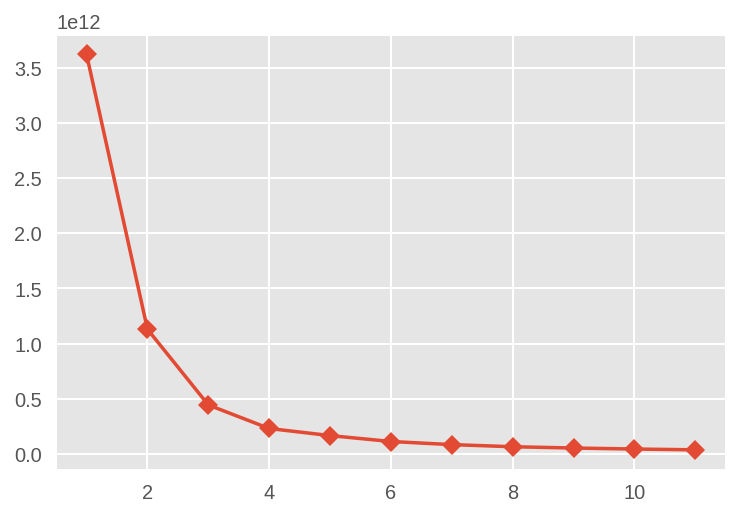

In [ ]:
# CLUSTER PARA INFECTADOS

# selecciono las columnas que tocan, sin la columna de confirmados en ete caso
X = datos_comorbilidades.drop(['fecha', 'ccaa', 'confirmados'], axis=1) 

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False, locate_elbow=False)

visualizer.fit(X)     # Fit the data to the visualizer
visualizer.poof      # Finalize and render the figure

<bound method Visualizer.poof of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f77618b7710>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=11,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=False, metric='distortion',
                 timings=False)>

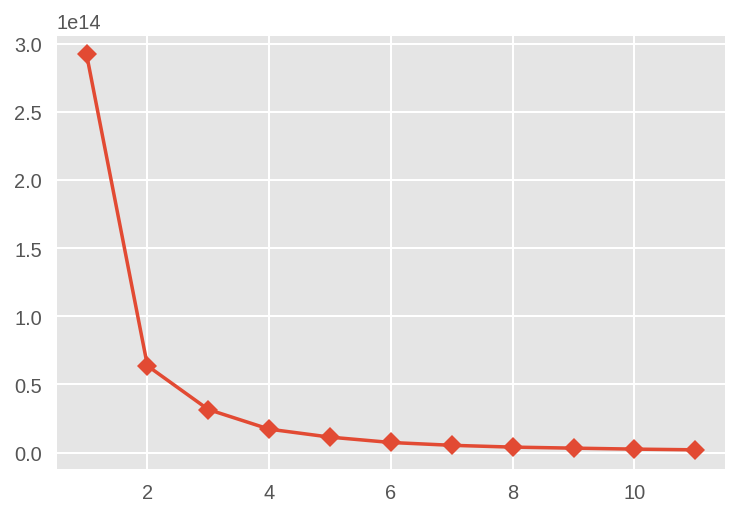

In [ ]:
# CLUSTER PARA INFECTADOS

# selecciono las columnas que tocan, sin la columna de confirmados en ete caso
X = datos_comorbilidades.drop(['fecha', 'ccaa', 'hospitalizados'], axis=1) 

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False, locate_elbow=False)

visualizer.fit(X)     # Fit the data to the visualizer
visualizer.poof      # Finalize and render the figure

<bound method Visualizer.poof of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7761942cd0>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=11,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=False, metric='distortion',
                 timings=False)>

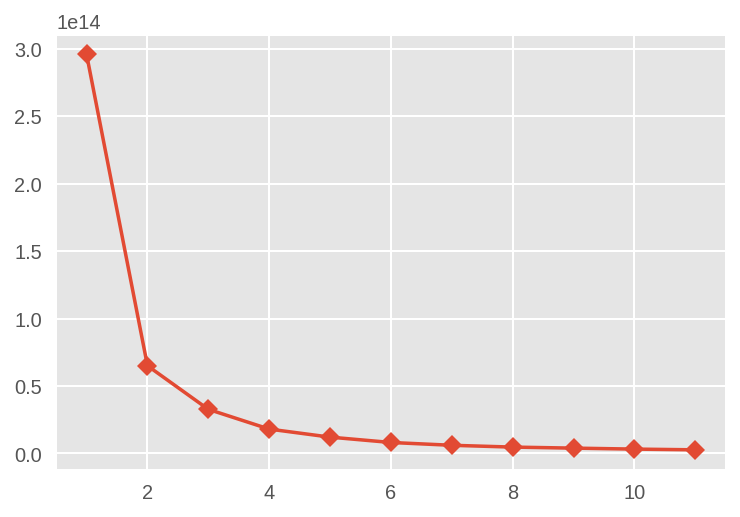

In [ ]:
# CLUSTER PARA INFECTADOS

# selecciono las columnas que tocan, sin la columna de confirmados en ete caso
X = datos_comorbilidades.drop(['fecha', 'ccaa', 'uci'], axis=1) 

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False, locate_elbow=False)

visualizer.fit(X)     # Fit the data to the visualizer
visualizer.poof      # Finalize and render the figure

<bound method Visualizer.poof of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f77619ccd10>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=11,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=False, metric='distortion',
                 timings=False)>

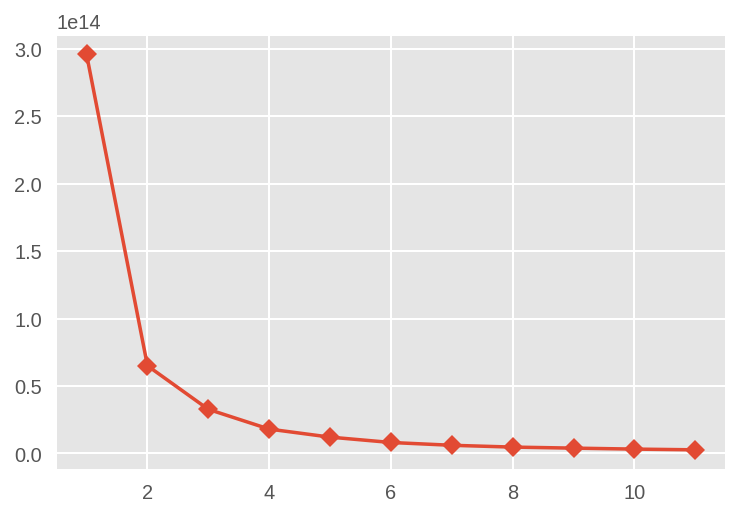

In [ ]:
# CLUSTER PARA INFECTADOS

# selecciono las columnas que tocan, sin la columna de confirmados en ete caso
X = datos_comorbilidades.drop(['fecha', 'ccaa', 'fallecidos'], axis=1) 

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False, locate_elbow=False)

visualizer.fit(X)     # Fit the data to the visualizer
visualizer.poof      # Finalize and render the figure

## PRUEBA CLUSTER

### cluster demograficos

In [ ]:
datos_demograficos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   fecha                      10370 non-null  object  
 1   ccaa                       10370 non-null  category
 2   confirmados                10370 non-null  int32   
 3   hospitalizados             10370 non-null  int32   
 4   fallecidos                 10370 non-null  int32   
 5   uci                        10370 non-null  int32   
 6   Edad Media (años)          10370 non-null  float64 
 7   Mayores 65 años (%)        10370 non-null  float64 
 8   Mayores 75 años(%)         10370 non-null  float64 
 9   Índice de dependencia      10370 non-null  float64 
 10  Tasa de Mortalidad (2017)  10370 non-null  float64 
 11  Tasa de Mortalidad (2018)  10370 non-null  float64 
 12  Tasa de Mortalidad (2019)  10370 non-null  float64 
 13  Esperanza_nascer           1037

In [ ]:
datos_demograficos.ccaa.unique()

['Andalucía', 'Aragón', 'Asturias', 'Canarias', 'Cantabria', ..., 'La Rioja', 'Madrid', 'Murcia', 'Navarra', 'País Vasco']
Length: 17
Categories (17, object): ['Andalucía', 'Aragón', 'Asturias', 'Canarias', ..., 'Madrid', 'Murcia',
                          'Navarra', 'País Vasco']

In [ ]:
#fecha
#datos_demograficos.fecha = datos_demograficos.fecha.strftime('%d%m%Y')
nueva_fecha = datos_demograficos['fecha'].apply(lambda x: x.strftime('%d%m%Y')) 
nueva_fecha1 = pd.to_numeric(nueva_fecha, errors='coerce')
#df['A'].apply(lambda x: x.strftime('%d%m%Y'))

## ccaa
datos_demograficos['ccaa'] = datos_demograficos['ccaa'].cat.codes
datos_demograficos['fecha'] =  nueva_fecha1
datos_demograficos.info()
datos_demograficos.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fecha                      10370 non-null  int64  
 1   ccaa                       10370 non-null  int8   
 2   confirmados                10370 non-null  int32  
 3   hospitalizados             10370 non-null  int32  
 4   fallecidos                 10370 non-null  int32  
 5   uci                        10370 non-null  int32  
 6   Edad Media (años)          10370 non-null  float64
 7   Mayores 65 años (%)        10370 non-null  float64
 8   Mayores 75 años(%)         10370 non-null  float64
 9   Índice de dependencia      10370 non-null  float64
 10  Tasa de Mortalidad (2017)  10370 non-null  float64
 11  Tasa de Mortalidad (2018)  10370 non-null  float64
 12  Tasa de Mortalidad (2019)  10370 non-null  float64
 13  Esperanza_nascer           10370 non-null  flo

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental
0,1012020,0,0,3,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5
1,2012020,0,0,8,0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5


In [ ]:
datos_demograficos.ccaa.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11, 12, 13, 14, 15, 16, 17, 19],
      dtype=int8)

pruebo los del cluster

In [ ]:
df_cm2 = datos_demograficos
df_cm2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fecha                      10370 non-null  int64  
 1   ccaa                       10370 non-null  int8   
 2   confirmados                10370 non-null  int32  
 3   hospitalizados             10370 non-null  int32  
 4   fallecidos                 10370 non-null  int32  
 5   uci                        10370 non-null  int32  
 6   Edad Media (años)          10370 non-null  float64
 7   Mayores 65 años (%)        10370 non-null  float64
 8   Mayores 75 años(%)         10370 non-null  float64
 9   Índice de dependencia      10370 non-null  float64
 10  Tasa de Mortalidad (2017)  10370 non-null  float64
 11  Tasa de Mortalidad (2018)  10370 non-null  float64
 12  Tasa de Mortalidad (2019)  10370 non-null  float64
 13  Esperanza_nascer           10370 non-null  flo

In [ ]:
cols_needed=['Edad Media (años)','Mayores 65 años (%)','Mayores 75 años(%)', 'Índice de dependencia', 'Tasa de Mortalidad (2017)', 'Tasa de Mortalidad (2018)', 'Tasa de Mortalidad (2019)', 'Esperanza_nascer','Esperanza_65años','Mala_salud_mental', 'confirmados',
       'hospitalizados', 'uci', 'fallecidos']

In [ ]:
#data2=data2[~data2.ccaa.isin(excluded_cntry)]
if len(cols_needed)==0:
    data2_sub=df_cm2.select_dtypes(include='float')
else:
    data2_sub=df_cm2[cols_needed]
data2_sub=pd.concat([data2_sub,df_cm2[['ccaa']]],axis=1)
data2_sub=data2_sub.groupby('ccaa').mean().reset_index()
data2_sub.fillna(0,inplace=True)

In [ ]:
data2_sub.head(1)

,ccaa,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental,confirmados,hospitalizados,uci,fallecidos
0,0,42.48,17.41,8.25,51.61,26.5,8.35,8.66,81.94,20.25,26.5,254012.996721,22072.337705,2430.94918,4648.159016


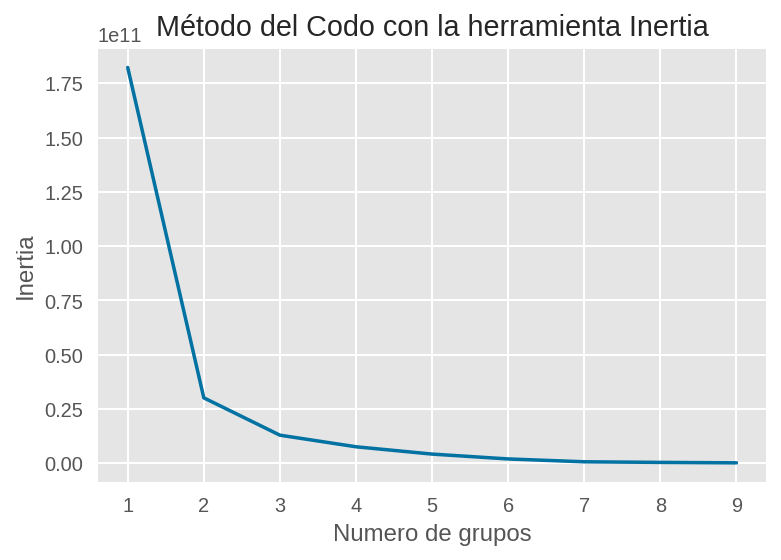

In [ ]:
inertias = [] 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data2_sub.drop(['ccaa'],axis=1)) 
    kmeanModel.fit(data2_sub)     
    inertias.append(kmeanModel.inertia_) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Numero de grupos') 
plt.ylabel('Inertia') 
plt.title('Método del Codo con la herramienta Inertia') 
plt.show()

In [ ]:
# ajustado el algoritmo Kmeans ak conjunto de datos
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 4 clústers
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data2_sub.drop(['ccaa'],axis=1))
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub=data2_sub.drop(['ccaa'],axis=1)
# Adding cluster to the Dataset
today_sub['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub.groupby('cluster').mean(),1))

## Identificación de los valores promedio ( centroides) 
kmeans_mean_cluster

,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental,confirmados,hospitalizados,uci,fallecidos
cluster,,,,,,,,,,,,,,
1,44.7,20.6,9.9,54.4,14.3,9.5,9.8,83.3,21.4,14.3,34799.8,3764.5,440.8,818.9
2,43.1,18.5,7.8,53.2,23.8,8.6,8.9,82.4,20.6,23.8,214912.8,19761.5,2109.6,4090.2
3,45.7,22.5,11.9,58.3,17.1,10.5,10.6,84.0,22.0,17.1,98071.1,12385.8,941.5,3432.1
4,42.9,18.6,9.2,54.1,15.9,7.8,8.0,84.5,22.4,15.9,326829.1,43699.6,3384.1,9460.8


In [ ]:
today_Sub_2=pd.concat([data2_sub[['ccaa']],today_sub],axis=1)
today_Sub_2.head(10)


,ccaa,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental,confirmados,hospitalizados,uci,fallecidos,cluster
0,0,42.48,17.41,8.25,51.61,26.50,8.35,8.66,81.94,20.25,26.50,254012.996721,22072.337705,2430.949180,4648.159016,2
1,1,45.12,21.73,11.44,58.07,12.54,10.28,10.72,83.71,21.65,12.54,60739.214754,6934.442623,675.072131,1928.465574,1
2,2,48.87,26.09,13.04,58.65,17.23,12.64,12.93,82.80,21.17,17.23,23685.878689,4022.672131,356.621311,963.975410,1
3,3,43.09,16.54,7.50,43.84,14.33,7.10,7.45,82.53,21.02,14.33,25556.100000,2710.529508,533.008197,379.970492,1
4,4,46.10,22.29,10.94,55.95,10.80,10.33,10.49,83.54,21.49,10.80,14702.342623,1519.106557,207.300000,322.734426,1
5,5,47.97,25.51,13.96,60.82,17.86,11.95,12.15,84.20,22.24,17.86,109289.768852,15024.537705,1169.640984,4062.522951,3
6,6,43.46,19.08,10.20,54.12,14.30,9.55,9.64,83.67,21.55,14.30,91993.262295,12781.313115,880.250820,3738.447541,3
7,7,43.12,19.22,9.53,55.69,16.36,8.48,8.86,83.67,21.69,16.36,304879.472131,25832.422951,2170.795082,8776.952459,4
8,9,43.79,19.67,7.32,54.71,21.07,8.80,9.16,82.79,20.97,21.07,175812.655738,17450.721311,1788.232787,3532.159016,2
9,11,45.01,20.89,9.49,54.29,7.68,10.60,10.73,82.68,20.80,7.68,34398.565574,3135.009836,271.798361,958.744262,1


In [ ]:
# sustituyo la fika de las ccaa por los nombres
today_Sub_2.ccaa.unique



<bound method Series.unique of 0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      9
9     11
10    12
11    13
12    14
13    15
14    16
15    17
16    19
Name: ccaa, dtype: int64>

In [ ]:
for i in range(1,5):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(today_Sub_2[today_Sub_2.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
[1, 2, 3, 4, 11, 12, 13, 14, 16, 17]
****Comunidades autónomas en el grupo 2*****
[0, 9]
****Comunidades autónomas en el grupo 3*****
[5, 6, 19]
****Comunidades autónomas en el grupo 4*****
[7, 15]


['Andalucía',
 'Aragón',
 'Asturias',
 'Canarias',
 'Cantabria',
 'Castilla y León',
 'Castilla-La Mancha',
 'Cataluña',
 'Comunidad Valenciana',
 'Extremadura',
 'Galicia',
 'Islas Baleares',
 'La Rioja',
 'Madrid',
 'Murcia',
 'Navarra',
 'País Vasco']

In [ ]:
# c
today_Sub_2['ccaa'] = today_Sub_2['ccaa'].astype(str)

In [ ]:
today_Sub_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ccaa                       17 non-null     int64  
 1   Edad Media (años)          17 non-null     float64
 2   Mayores 65 años (%)        17 non-null     float64
 3   Mayores 75 años(%)         17 non-null     float64
 4   Índice de dependencia      17 non-null     float64
 5   Tasa de Mortalidad (2017)  17 non-null     float64
 6   Tasa de Mortalidad (2018)  17 non-null     float64
 7   Tasa de Mortalidad (2019)  17 non-null     float64
 8   Esperanza_nascer           17 non-null     float64
 9   Esperanza_65años           17 non-null     float64
 10  Mala_salud_mental          17 non-null     float64
 11  confirmados                17 non-null     float64
 12  hospitalizados             17 non-null     float64
 13  uci                        17 non-null     float64
 

repito el proceso para comprobar si funciona

In [ ]:
today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('0','Andalucia')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('1','Aragón')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('2','Asturias')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('3','Canarias')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('4','Cantabria')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('5','Castilla y León')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('6','Castilla La Mancha')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('7','Cataluña')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('9','Comunidad Valenciana')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('11','Extremadura')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('12','Galicia')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('13','Islas Baleares')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('14','La Rioja')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('15','Madrid')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('16','Murcia')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('17','Navarra')

today_Sub_2['ccaa'] = today_Sub_2['ccaa'].str.replace('19','Pais Vasco')

In [ ]:
today_Sub_2

,ccaa,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental,confirmados,hospitalizados,uci,fallecidos,cluster
0,Andalucia,42.48,17.41,8.25,51.61,26.50,8.35,8.66,81.94,20.25,26.50,254012.996721,22072.337705,2430.949180,4648.159016,2
1,Aragón,45.12,21.73,11.44,58.07,12.54,10.28,10.72,83.71,21.65,12.54,60739.214754,6934.442623,675.072131,1928.465574,1
2,Asturias,48.87,26.09,13.04,58.65,17.23,12.64,12.93,82.80,21.17,17.23,23685.878689,4022.672131,356.621311,963.975410,1
3,Canarias,43.09,16.54,7.50,43.84,14.33,7.10,7.45,82.53,21.02,14.33,25556.100000,2710.529508,533.008197,379.970492,1
4,Cantabria,46.10,22.29,10.94,55.95,10.80,10.33,10.49,83.54,21.49,10.80,14702.342623,1519.106557,207.300000,322.734426,1
5,Castilla y León,47.97,25.51,13.96,60.82,17.86,11.95,12.15,84.20,22.24,17.86,109289.768852,15024.537705,1169.640984,4062.522951,3
6,Castilla La Mancha,43.46,19.08,10.20,54.12,14.30,9.55,9.64,83.67,21.55,14.30,91993.262295,12781.313115,880.250820,3738.447541,3
7,Cataluña,43.12,19.22,9.53,55.69,16.36,8.48,8.86,83.67,21.69,16.36,304879.472131,25832.422951,2170.795082,8776.952459,4
8,Comunidad Valenciana,43.79,19.67,7.32,54.71,21.07,8.80,9.16,82.79,20.97,21.07,175812.655738,17450.721311,1788.232787,3532.159016,2
9,Extremadura,45.01,20.89,9.49,54.29,7.68,10.60,10.73,82.68,20.80,7.68,34398.565574,3135.009836,271.798361,958.744262,1


In [ ]:
#df['name']= df['name'].replace(['michael','louis'],['karl','lionel'])


# c
today_Sub_2['ccaa'] = today_Sub_2['ccaa'].astype(str)
#today_Sub_2.info()


today_Sub_2['ccaa']= today_Sub_2['ccaa'].replace(['0','1','2', '3', '4', '5', '6', '7','9', '11', '12', '13', '14', '15','16','17', '19'],['Andalucia','Aragón','Asturias', 'Canarias', 'Cantabria', 'Castilla y León', 'Castilla La Mancha', 'Cataluña', 'Comunidad Valenciana', 'Extremadura', 'Galicia', 'Islas Baleares', 'La Rioja', 'Madrid', 'Murcia', 'Navarra', 'Pais Vasco' ])


today_Sub_2

,ccaa,Edad Media (años),Mayores 65 años (%),Mayores 75 años(%),Índice de dependencia,Tasa de Mortalidad (2017),Tasa de Mortalidad (2018),Tasa de Mortalidad (2019),Esperanza_nascer,Esperanza_65años,Mala_salud_mental,confirmados,hospitalizados,uci,fallecidos,cluster
0,Andalucia,42.48,17.41,8.25,51.61,26.50,8.35,8.66,81.94,20.25,26.50,254012.996721,22072.337705,2430.949180,4648.159016,2
1,Aragón,45.12,21.73,11.44,58.07,12.54,10.28,10.72,83.71,21.65,12.54,60739.214754,6934.442623,675.072131,1928.465574,1
2,Asturias,48.87,26.09,13.04,58.65,17.23,12.64,12.93,82.80,21.17,17.23,23685.878689,4022.672131,356.621311,963.975410,1
3,Canarias,43.09,16.54,7.50,43.84,14.33,7.10,7.45,82.53,21.02,14.33,25556.100000,2710.529508,533.008197,379.970492,1
4,Cantabria,46.10,22.29,10.94,55.95,10.80,10.33,10.49,83.54,21.49,10.80,14702.342623,1519.106557,207.300000,322.734426,1
5,Castilla y León,47.97,25.51,13.96,60.82,17.86,11.95,12.15,84.20,22.24,17.86,109289.768852,15024.537705,1169.640984,4062.522951,3
6,Castilla La Mancha,43.46,19.08,10.20,54.12,14.30,9.55,9.64,83.67,21.55,14.30,91993.262295,12781.313115,880.250820,3738.447541,3
7,Cataluña,43.12,19.22,9.53,55.69,16.36,8.48,8.86,83.67,21.69,16.36,304879.472131,25832.422951,2170.795082,8776.952459,4
8,Comunidad Valenciana,43.79,19.67,7.32,54.71,21.07,8.80,9.16,82.79,20.97,21.07,175812.655738,17450.721311,1788.232787,3532.159016,2
9,Extremadura,45.01,20.89,9.49,54.29,7.68,10.60,10.73,82.68,20.80,7.68,34398.565574,3135.009836,271.798361,958.744262,1


In [ ]:
import plotly
import plotly.express as px
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='confirmados')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [ ]:
import plotly
import plotly.express as px
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='hospitalizados')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [ ]:
import plotly
import plotly.express as px
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='uci')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [ ]:
import plotly
import plotly.express as px
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='fallecidos')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

### cluster hospitalarios

In [328]:
datos_hospitalarios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   fecha                          10370 non-null  object  
 1   ccaa                           10370 non-null  category
 2   confirmados                    10370 non-null  int32   
 3   hospitalizados                 10370 non-null  int32   
 4   fallecidos                     10370 non-null  int32   
 5   uci                            10370 non-null  int32   
 6   camas_funcionamiento           10370 non-null  float64 
 7   hospital_dia_funcionamiento    10370 non-null  float64 
 8   gasto_sanitario                10370 non-null  float64 
 9   infeccion_hospitalaria         10370 non-null  float64 
 10  frecuentacion_hospitalizacion  10370 non-null  float64 
dtypes: category(1), float64(5), int32(4), object(1)
memory usage: 740.0+ KB


In [329]:
datos_hospitalarios.ccaa.unique()

['Andalucía', 'Aragón', 'Asturias', 'Canarias', 'Cantabria', ..., 'La Rioja', 'Madrid', 'Murcia', 'Navarra', 'País Vasco']
Length: 17
Categories (17, object): ['Andalucía', 'Aragón', 'Asturias', 'Canarias', ..., 'Madrid', 'Murcia',
                          'Navarra', 'País Vasco']

In [330]:
#fecha
#datos_demograficos.fecha = datos_demograficos.fecha.strftime('%d%m%Y')
nueva_fecha = datos_hospitalarios['fecha'].apply(lambda x: x.strftime('%d%m%Y')) 
nueva_fecha1 = pd.to_numeric(nueva_fecha, errors='coerce')
#df['A'].apply(lambda x: x.strftime('%d%m%Y'))

## ccaa
datos_hospitalarios['ccaa'] = datos_hospitalarios['ccaa'].cat.codes
datos_hospitalarios['fecha'] =  nueva_fecha1
datos_hospitalarios.info()
datos_hospitalarios.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   fecha                          10370 non-null  int64  
 1   ccaa                           10370 non-null  int8   
 2   confirmados                    10370 non-null  int32  
 3   hospitalizados                 10370 non-null  int32  
 4   fallecidos                     10370 non-null  int32  
 5   uci                            10370 non-null  int32  
 6   camas_funcionamiento           10370 non-null  float64
 7   hospital_dia_funcionamiento    10370 non-null  float64
 8   gasto_sanitario                10370 non-null  float64
 9   infeccion_hospitalaria         10370 non-null  float64
 10  frecuentacion_hospitalizacion  10370 non-null  float64
dtypes: float64(5), int32(4), int64(1), int8(1)
memory usage: 739.3 KB


,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,camas_funcionamiento,hospital_dia_funcionamiento,gasto_sanitario,infeccion_hospitalaria,frecuentacion_hospitalizacion
0,1012020,0,0,3,0,0,77.03,86.98,1264.66,1.33,69.18
1,2012020,0,0,8,0,0,77.03,86.98,1264.66,1.33,69.18


In [331]:
datos_hospitalarios.ccaa.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11, 12, 13, 14, 15, 16, 17, 19],
      dtype=int8)

pruebo los del cluster

In [332]:
df_cm2 = datos_hospitalarios
df_cm2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   fecha                          10370 non-null  int64  
 1   ccaa                           10370 non-null  int8   
 2   confirmados                    10370 non-null  int32  
 3   hospitalizados                 10370 non-null  int32  
 4   fallecidos                     10370 non-null  int32  
 5   uci                            10370 non-null  int32  
 6   camas_funcionamiento           10370 non-null  float64
 7   hospital_dia_funcionamiento    10370 non-null  float64
 8   gasto_sanitario                10370 non-null  float64
 9   infeccion_hospitalaria         10370 non-null  float64
 10  frecuentacion_hospitalizacion  10370 non-null  float64
dtypes: float64(5), int32(4), int64(1), int8(1)
memory usage: 739.3 KB


In [333]:
cols_needed=['camas_funcionamiento', 'hospital_dia_funcionamiento', 'gasto_sanitario', 'infeccion_hospitalaria', 'frecuentacion_hospitalizacion', 'confirmados',
       'hospitalizados', 'uci', 'fallecidos']

In [334]:
#data2=data2[~data2.ccaa.isin(excluded_cntry)]
if len(cols_needed)==0:
    data2_sub=df_cm2.select_dtypes(include='float')
else:
    data2_sub=df_cm2[cols_needed]
data2_sub=pd.concat([data2_sub,df_cm2[['ccaa']]],axis=1)
data2_sub=data2_sub.groupby('ccaa').mean().reset_index()
data2_sub.fillna(0,inplace=True)

In [335]:
data2_sub.head(1)

,ccaa,camas_funcionamiento,hospital_dia_funcionamiento,gasto_sanitario,infeccion_hospitalaria,frecuentacion_hospitalizacion,confirmados,hospitalizados,uci,fallecidos
0,0,77.03,86.98,1264.66,1.33,69.18,254012.996721,22072.337705,2430.94918,4648.159016


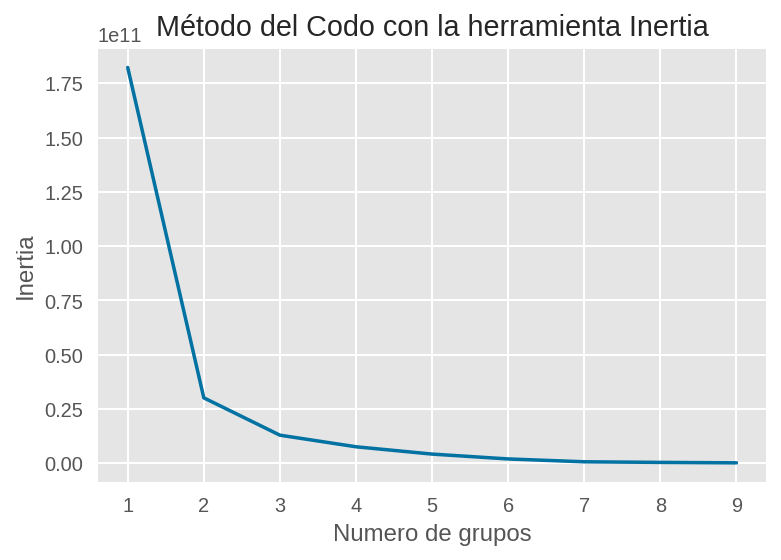

In [336]:
inertias = [] 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data2_sub.drop(['ccaa'],axis=1)) 
    kmeanModel.fit(data2_sub)     
    inertias.append(kmeanModel.inertia_) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Numero de grupos') 
plt.ylabel('Inertia') 
plt.title('Método del Codo con la herramienta Inertia') 
plt.show()

In [337]:
# ajustado el algoritmo Kmeans ak conjunto de datos
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 4 clústers
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data2_sub.drop(['ccaa'],axis=1))
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub=data2_sub.drop(['ccaa'],axis=1)
# Adding cluster to the Dataset
today_sub['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub.groupby('cluster').mean(),1))

## Identificación de los valores promedio ( centroides) 
kmeans_mean_cluster

,camas_funcionamiento,hospital_dia_funcionamiento,gasto_sanitario,infeccion_hospitalaria,frecuentacion_hospitalizacion,confirmados,hospitalizados,uci,fallecidos
cluster,,,,,,,,,
1,79.1,85.1,1591.2,1.1,79.7,34799.8,3764.5,440.8,818.9
2,81.3,90.0,1379.3,1.1,73.7,214912.8,19761.5,2109.6,4090.2
3,83.7,90.3,1624.8,1.0,87.6,98071.1,12385.8,941.5,3432.1
4,79.9,86.5,1390.7,1.3,72.9,326829.1,43699.6,3384.1,9460.8


In [338]:
today_Sub_2=pd.concat([data2_sub[['ccaa']],today_sub],axis=1)
today_Sub_2.head(10)


,ccaa,camas_funcionamiento,hospital_dia_funcionamiento,gasto_sanitario,infeccion_hospitalaria,frecuentacion_hospitalizacion,confirmados,hospitalizados,uci,fallecidos,cluster
0,0,77.03,86.98,1264.66,1.33,69.18,254012.996721,22072.337705,2430.949180,4648.159016,2
1,1,85.10,86.14,1620.35,1.12,83.99,60739.214754,6934.442623,675.072131,1928.465574,1
2,2,85.91,92.80,1683.67,0.76,89.14,23685.878689,4022.672131,356.621311,963.975410,1
3,3,68.82,86.68,1530.02,1.60,59.07,25556.100000,2710.529508,533.008197,379.970492,1
4,4,72.82,60.28,1588.10,1.62,88.91,14702.342623,1519.106557,207.300000,322.734426,1
5,5,75.72,88.47,1628.89,1.08,87.26,109289.768852,15024.537705,1169.640984,4062.522951,3
6,6,93.27,94.82,1510.73,0.77,89.82,91993.262295,12781.313115,880.250820,3738.447541,3
7,7,89.03,92.10,1492.08,1.14,80.24,304879.472131,25832.422951,2170.795082,8776.952459,4
8,9,85.60,93.00,1493.93,0.81,78.22,175812.655738,17450.721311,1788.232787,3532.159016,2
9,11,94.19,98.53,1663.26,0.80,87.51,34398.565574,3135.009836,271.798361,958.744262,1


In [339]:
# sustituyo la fika de las ccaa por los nombres
today_Sub_2.ccaa.unique



<bound method Series.unique of 0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      9
9     11
10    12
11    13
12    14
13    15
14    16
15    17
16    19
Name: ccaa, dtype: int64>

In [340]:
for i in range(1,5):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(today_Sub_2[today_Sub_2.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
[1, 2, 3, 4, 11, 12, 13, 14, 16, 17]
****Comunidades autónomas en el grupo 2*****
[0, 9]
****Comunidades autónomas en el grupo 3*****
[5, 6, 19]
****Comunidades autónomas en el grupo 4*****
[7, 15]


['Andalucía',
 'Aragón',
 'Asturias',
 'Canarias',
 'Cantabria',
 'Castilla y León',
 'Castilla-La Mancha',
 'Cataluña',
 'Comunidad Valenciana',
 'Extremadura',
 'Galicia',
 'Islas Baleares',
 'La Rioja',
 'Madrid',
 'Murcia',
 'Navarra',
 'País Vasco']

In [341]:
# c
today_Sub_2['ccaa'] = today_Sub_2['ccaa'].astype(str)

In [342]:
today_Sub_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ccaa                           17 non-null     object 
 1   camas_funcionamiento           17 non-null     float64
 2   hospital_dia_funcionamiento    17 non-null     float64
 3   gasto_sanitario                17 non-null     float64
 4   infeccion_hospitalaria         17 non-null     float64
 5   frecuentacion_hospitalizacion  17 non-null     float64
 6   confirmados                    17 non-null     float64
 7   hospitalizados                 17 non-null     float64
 8   uci                            17 non-null     float64
 9   fallecidos                     17 non-null     float64
 10  cluster                        17 non-null     int32  
dtypes: float64(9), int32(1), object(1)
memory usage: 1.5+ KB


repito el proceso para comprobar si funciona

In [343]:
today_Sub_2

,ccaa,camas_funcionamiento,hospital_dia_funcionamiento,gasto_sanitario,infeccion_hospitalaria,frecuentacion_hospitalizacion,confirmados,hospitalizados,uci,fallecidos,cluster
0,0,77.03,86.98,1264.66,1.33,69.18,254012.996721,22072.337705,2430.949180,4648.159016,2
1,1,85.10,86.14,1620.35,1.12,83.99,60739.214754,6934.442623,675.072131,1928.465574,1
2,2,85.91,92.80,1683.67,0.76,89.14,23685.878689,4022.672131,356.621311,963.975410,1
3,3,68.82,86.68,1530.02,1.60,59.07,25556.100000,2710.529508,533.008197,379.970492,1
4,4,72.82,60.28,1588.10,1.62,88.91,14702.342623,1519.106557,207.300000,322.734426,1
5,5,75.72,88.47,1628.89,1.08,87.26,109289.768852,15024.537705,1169.640984,4062.522951,3
6,6,93.27,94.82,1510.73,0.77,89.82,91993.262295,12781.313115,880.250820,3738.447541,3
7,7,89.03,92.10,1492.08,1.14,80.24,304879.472131,25832.422951,2170.795082,8776.952459,4
8,9,85.60,93.00,1493.93,0.81,78.22,175812.655738,17450.721311,1788.232787,3532.159016,2
9,11,94.19,98.53,1663.26,0.80,87.51,34398.565574,3135.009836,271.798361,958.744262,1


In [344]:
#df['name']= df['name'].replace(['michael','louis'],['karl','lionel'])


# c
today_Sub_2['ccaa'] = today_Sub_2['ccaa'].astype(str)
#today_Sub_2.info()


today_Sub_2['ccaa']= today_Sub_2['ccaa'].replace(['0','1','2', '3', '4', '5', '6', '7','9', '11', '12', '13', '14', '15','16','17', '19'],['Andalucia','Aragón','Asturias', 'Canarias', 'Cantabria', 'Castilla y León', 'Castilla La Mancha', 'Cataluña', 'Comunidad Valenciana', 'Extremadura', 'Galicia', 'Islas Baleares', 'La Rioja', 'Madrid', 'Murcia', 'Navarra', 'Pais Vasco' ])


today_Sub_2

,ccaa,camas_funcionamiento,hospital_dia_funcionamiento,gasto_sanitario,infeccion_hospitalaria,frecuentacion_hospitalizacion,confirmados,hospitalizados,uci,fallecidos,cluster
0,Andalucia,77.03,86.98,1264.66,1.33,69.18,254012.996721,22072.337705,2430.949180,4648.159016,2
1,Aragón,85.10,86.14,1620.35,1.12,83.99,60739.214754,6934.442623,675.072131,1928.465574,1
2,Asturias,85.91,92.80,1683.67,0.76,89.14,23685.878689,4022.672131,356.621311,963.975410,1
3,Canarias,68.82,86.68,1530.02,1.60,59.07,25556.100000,2710.529508,533.008197,379.970492,1
4,Cantabria,72.82,60.28,1588.10,1.62,88.91,14702.342623,1519.106557,207.300000,322.734426,1
5,Castilla y León,75.72,88.47,1628.89,1.08,87.26,109289.768852,15024.537705,1169.640984,4062.522951,3
6,Castilla La Mancha,93.27,94.82,1510.73,0.77,89.82,91993.262295,12781.313115,880.250820,3738.447541,3
7,Cataluña,89.03,92.10,1492.08,1.14,80.24,304879.472131,25832.422951,2170.795082,8776.952459,4
8,Comunidad Valenciana,85.60,93.00,1493.93,0.81,78.22,175812.655738,17450.721311,1788.232787,3532.159016,2
9,Extremadura,94.19,98.53,1663.26,0.80,87.51,34398.565574,3135.009836,271.798361,958.744262,1


In [345]:
import plotly
import plotly.express as px
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='confirmados')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [346]:
import plotly
import plotly.express as px
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='hospitalizados')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [347]:
import plotly
import plotly.express as px
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='uci')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [349]:
import plotly
import plotly.express as px
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='fallecidos')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

### cluster comorbilidades

In [368]:
datos_comorbilidades.head(2)

,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,VIH,Diabetes,trastornos mentales,asma,EPOC
0,1012020,Andalucía,0,3,0,0,7.27,8.25,12.0,4.93,3.42
1,2012020,Andalucía,0,8,0,0,7.27,8.25,12.0,4.93,3.42


In [369]:
datos_comorbilidades.ccaa.unique()

['Andalucía', 'Aragón', 'Asturias', 'Canarias', 'Cantabria', ..., 'La Rioja', 'Madrid', 'Murcia', 'Navarra', 'País Vasco']
Length: 17
Categories (17, object): ['Andalucía', 'Aragón', 'Asturias', 'Canarias', ..., 'Madrid', 'Murcia',
                          'Navarra', 'País Vasco']

In [372]:
#fecha
#datos_demograficos.fecha = datos_demograficos.fecha.strftime('%d%m%Y')
#nueva_fecha = datos_comorbilidades['fecha'].apply(lambda x: x.strftime('%d%m%Y')) 
#nueva_fecha1 = pd.to_numeric(nueva_fecha, errors='coerce')
#df['A'].apply(lambda x: x.strftime('%d%m%Y'))

## ccaa
datos_comorbilidades['ccaa'] = datos_comorbilidades['ccaa'].cat.codes
datos_comorbilidades['fecha'] =  nueva_fecha1
datos_comorbilidades.info()
datos_comorbilidades.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fecha                10370 non-null  int64  
 1   ccaa                 10370 non-null  int8   
 2   confirmados          10370 non-null  int32  
 3   hospitalizados       10370 non-null  int32  
 4   fallecidos           10370 non-null  int32  
 5   uci                  10370 non-null  int32  
 6   VIH                  10370 non-null  float64
 7   Diabetes             10370 non-null  float64
 8   trastornos mentales  10370 non-null  float64
 9   asma                 10370 non-null  float64
 10  EPOC                 10370 non-null  float64
dtypes: float64(5), int32(4), int64(1), int8(1)
memory usage: 739.3 KB


,fecha,ccaa,confirmados,hospitalizados,fallecidos,uci,VIH,Diabetes,trastornos mentales,asma,EPOC
0,1012020,0,0,3,0,0,7.27,8.25,12.0,4.93,3.42
1,2012020,0,0,8,0,0,7.27,8.25,12.0,4.93,3.42


In [373]:
datos_comorbilidades.ccaa.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11, 12, 13, 14, 15, 16, 17, 19],
      dtype=int8)

pruebo los del cluster

In [374]:
df_cm2 = datos_comorbilidades
df_cm2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10370 entries, 0 to 10369
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fecha                10370 non-null  int64  
 1   ccaa                 10370 non-null  int8   
 2   confirmados          10370 non-null  int32  
 3   hospitalizados       10370 non-null  int32  
 4   fallecidos           10370 non-null  int32  
 5   uci                  10370 non-null  int32  
 6   VIH                  10370 non-null  float64
 7   Diabetes             10370 non-null  float64
 8   trastornos mentales  10370 non-null  float64
 9   asma                 10370 non-null  float64
 10  EPOC                 10370 non-null  float64
dtypes: float64(5), int32(4), int64(1), int8(1)
memory usage: 739.3 KB


In [375]:
cols_needed=['VIH', 'Diabetes', 'trastornos mentales', 'asma', 'EPOC', 'confirmados',
       'hospitalizados', 'uci', 'fallecidos']

In [376]:
#data2=data2[~data2.ccaa.isin(excluded_cntry)]
if len(cols_needed)==0:
    data2_sub=df_cm2.select_dtypes(include='float')
else:
    data2_sub=df_cm2[cols_needed]
data2_sub=pd.concat([data2_sub,df_cm2[['ccaa']]],axis=1)
data2_sub=data2_sub.groupby('ccaa').mean().reset_index()
data2_sub.fillna(0,inplace=True)

In [377]:
data2_sub.head(1)

,ccaa,VIH,Diabetes,trastornos mentales,asma,EPOC,confirmados,hospitalizados,uci,fallecidos
0,0,7.27,8.25,12.0,4.93,3.42,254012.996721,22072.337705,2430.94918,4648.159016


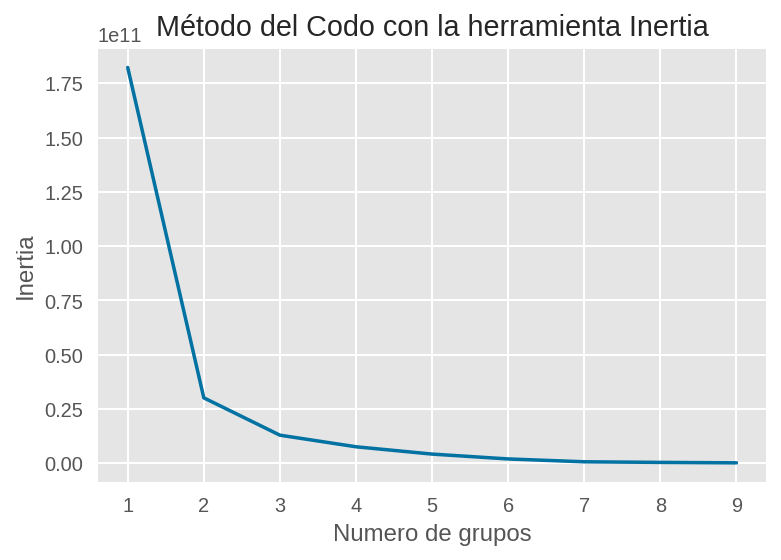

In [378]:
inertias = [] 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data2_sub.drop(['ccaa'],axis=1)) 
    kmeanModel.fit(data2_sub)     
    inertias.append(kmeanModel.inertia_) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Numero de grupos') 
plt.ylabel('Inertia') 
plt.title('Método del Codo con la herramienta Inertia') 
plt.show()

In [381]:
# ajustado el algoritmo Kmeans ak conjunto de datos
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 2 clústers
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data2_sub.drop(['ccaa'],axis=1))
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub=data2_sub.drop(['ccaa'],axis=1)
# Adding cluster to the Dataset
today_sub['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub.groupby('cluster').mean(),1))

## Identificación de los valores promedio ( centroides) 
kmeans_mean_cluster

,VIH,Diabetes,trastornos mentales,asma,EPOC,confirmados,hospitalizados,uci,fallecidos
cluster,,,,,,,,,
1,7.2,7.7,11.1,5.2,3.4,34799.8,3764.5,440.8,818.9
2,8.0,8.1,11.2,4.3,2.9,214912.8,19761.5,2109.6,4090.2
3,5.4,7.3,10.6,4.9,3.4,98071.1,12385.8,941.5,3432.1
4,11.0,7.2,9.3,4.2,2.6,326829.1,43699.6,3384.1,9460.8


In [380]:
today_Sub_2=pd.concat([data2_sub[['ccaa']],today_sub],axis=1)
today_Sub_2.head(10)


,ccaa,VIH,Diabetes,trastornos mentales,asma,EPOC,confirmados,hospitalizados,uci,fallecidos,cluster
0,0,7.27,8.25,12.00,4.93,3.42,254012.996721,22072.337705,2430.949180,4648.159016,2
1,1,8.51,7.90,8.62,3.86,4.29,60739.214754,6934.442623,675.072131,1928.465574,1
2,2,5.27,8.66,18.68,5.71,4.68,23685.878689,4022.672131,356.621311,963.975410,1
3,3,12.43,10.99,9.66,3.81,1.71,25556.100000,2710.529508,533.008197,379.970492,1
4,4,5.34,5.95,12.18,6.90,2.74,14702.342623,1519.106557,207.300000,322.734426,1
5,5,4.69,7.42,10.31,5.53,4.29,109289.768852,15024.537705,1169.640984,4062.522951,3
6,6,3.69,7.53,11.16,4.30,3.55,91993.262295,12781.313115,880.250820,3738.447541,3
7,7,8.85,7.01,10.38,3.52,3.04,304879.472131,25832.422951,2170.795082,8776.952459,4
8,9,8.71,8.02,10.42,3.67,2.33,175812.655738,17450.721311,1788.232787,3532.159016,2
9,11,2.53,9.19,8.78,4.38,4.27,34398.565574,3135.009836,271.798361,958.744262,1


In [382]:
# sustituyo la fika de las ccaa por los nombres
today_Sub_2.ccaa.unique



<bound method Series.unique of 0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      9
9     11
10    12
11    13
12    14
13    15
14    16
15    17
16    19
Name: ccaa, dtype: int64>

In [383]:
for i in range(1,5):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(today_Sub_2[today_Sub_2.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
[1, 2, 3, 4, 11, 12, 13, 14, 16, 17]
****Comunidades autónomas en el grupo 2*****
[0, 9]
****Comunidades autónomas en el grupo 3*****
[5, 6, 19]
****Comunidades autónomas en el grupo 4*****
[7, 15]


['Andalucía',
 'Aragón',
 'Asturias',
 'Canarias',
 'Cantabria',
 'Castilla y León',
 'Castilla-La Mancha',
 'Cataluña',
 'Comunidad Valenciana',
 'Extremadura',
 'Galicia',
 'Islas Baleares',
 'La Rioja',
 'Madrid',
 'Murcia',
 'Navarra',
 'País Vasco']

In [384]:
# c
today_Sub_2['ccaa'] = today_Sub_2['ccaa'].astype(str)

In [385]:
today_Sub_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ccaa                 17 non-null     object 
 1   VIH                  17 non-null     float64
 2   Diabetes             17 non-null     float64
 3   trastornos mentales  17 non-null     float64
 4   asma                 17 non-null     float64
 5   EPOC                 17 non-null     float64
 6   confirmados          17 non-null     float64
 7   hospitalizados       17 non-null     float64
 8   uci                  17 non-null     float64
 9   fallecidos           17 non-null     float64
 10  cluster              17 non-null     int32  
dtypes: float64(9), int32(1), object(1)
memory usage: 1.5+ KB


repito el proceso para comprobar si funciona

In [386]:
today_Sub_2

,ccaa,VIH,Diabetes,trastornos mentales,asma,EPOC,confirmados,hospitalizados,uci,fallecidos,cluster
0,0,7.27,8.25,12.00,4.93,3.42,254012.996721,22072.337705,2430.949180,4648.159016,2
1,1,8.51,7.90,8.62,3.86,4.29,60739.214754,6934.442623,675.072131,1928.465574,1
2,2,5.27,8.66,18.68,5.71,4.68,23685.878689,4022.672131,356.621311,963.975410,1
3,3,12.43,10.99,9.66,3.81,1.71,25556.100000,2710.529508,533.008197,379.970492,1
4,4,5.34,5.95,12.18,6.90,2.74,14702.342623,1519.106557,207.300000,322.734426,1
5,5,4.69,7.42,10.31,5.53,4.29,109289.768852,15024.537705,1169.640984,4062.522951,3
6,6,3.69,7.53,11.16,4.30,3.55,91993.262295,12781.313115,880.250820,3738.447541,3
7,7,8.85,7.01,10.38,3.52,3.04,304879.472131,25832.422951,2170.795082,8776.952459,4
8,9,8.71,8.02,10.42,3.67,2.33,175812.655738,17450.721311,1788.232787,3532.159016,2
9,11,2.53,9.19,8.78,4.38,4.27,34398.565574,3135.009836,271.798361,958.744262,1


In [387]:
#df['name']= df['name'].replace(['michael','louis'],['karl','lionel'])


# c
today_Sub_2['ccaa'] = today_Sub_2['ccaa'].astype(str)
#today_Sub_2.info()


today_Sub_2['ccaa']= today_Sub_2['ccaa'].replace(['0','1','2', '3', '4', '5', '6', '7','9', '11', '12', '13', '14', '15','16','17', '19'],['Andalucia','Aragón','Asturias', 'Canarias', 'Cantabria', 'Castilla y León', 'Castilla La Mancha', 'Cataluña', 'Comunidad Valenciana', 'Extremadura', 'Galicia', 'Islas Baleares', 'La Rioja', 'Madrid', 'Murcia', 'Navarra', 'Pais Vasco' ])


today_Sub_2

,ccaa,VIH,Diabetes,trastornos mentales,asma,EPOC,confirmados,hospitalizados,uci,fallecidos,cluster
0,Andalucia,7.27,8.25,12.00,4.93,3.42,254012.996721,22072.337705,2430.949180,4648.159016,2
1,Aragón,8.51,7.90,8.62,3.86,4.29,60739.214754,6934.442623,675.072131,1928.465574,1
2,Asturias,5.27,8.66,18.68,5.71,4.68,23685.878689,4022.672131,356.621311,963.975410,1
3,Canarias,12.43,10.99,9.66,3.81,1.71,25556.100000,2710.529508,533.008197,379.970492,1
4,Cantabria,5.34,5.95,12.18,6.90,2.74,14702.342623,1519.106557,207.300000,322.734426,1
5,Castilla y León,4.69,7.42,10.31,5.53,4.29,109289.768852,15024.537705,1169.640984,4062.522951,3
6,Castilla La Mancha,3.69,7.53,11.16,4.30,3.55,91993.262295,12781.313115,880.250820,3738.447541,3
7,Cataluña,8.85,7.01,10.38,3.52,3.04,304879.472131,25832.422951,2170.795082,8776.952459,4
8,Comunidad Valenciana,8.71,8.02,10.42,3.67,2.33,175812.655738,17450.721311,1788.232787,3532.159016,2
9,Extremadura,2.53,9.19,8.78,4.38,4.27,34398.565574,3135.009836,271.798361,958.744262,1


In [389]:
import plotly
import plotly.express as px
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='confirmados')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [392]:
import plotly
import plotly.express as px
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='hospitalizados')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [393]:
import plotly
import plotly.express as px
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='uci')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [394]:
import plotly
import plotly.express as px
#import plotly.express as px
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='fallecidos')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()